# Electricity Provisioning based on Demand Prediction - Shubham Agrawal - 113166701

The goal of this assignment is to test the performance of different electricity provisioning algorithms based on the demand predictions obtained in Assignment 1.

Objective is to utilize existing provisioning algorithms (online gradient descent, online balanced descent, receding horizon control, commitment horizon control) to provision electricity for each user.

## Importing libraries

In [261]:
import pandas as pd
import numpy as np
from cvxpy import *
import cvxpy
import matplotlib.pyplot as plt
import math

## Reading and pre-processing Data

Using the separate datasets for 3 homes that contain the load demand (in kW) for each 30- minute interval that covers 1 year given in Assignmetn 1. Also, using the data set which is obtained after predicting for Nov 1 -14, using linear regression and random forest for all the three houses.
After reading the data, 
1. Converting into a dataframe
2. Converting 'Date & Time' column to datetime object so that we can leverage the properties of date field like comparisons, grouping, etc.
3. Grouping the fields for 30 minutes i.e. half hour intervals as this assignment requires to obtain load demand for 30 minute interval

In [262]:
# Reading Raw Data from Assignment 1
homebpowerdata = pd.read_csv("/Users/admin/Downloads/SBU-US/Smart Energy/assignment-1/data/Home B - 2014/HomeB-meter1_2014.csv")
homecpowerdata = pd.read_csv("/Users/admin/Downloads/SBU-US/Smart Energy/assignment-1/data/Home C - 2016/HomeC-meter1_2016.csv")
homefpowerdata = pd.read_csv("/Users/admin/Downloads/SBU-US/Smart Energy/assignment-1/data/Home F - 2016/HomeF-meter3_2016.csv")

# Reading Prediction Data from Assignment 1
homeblrpred=pd.read_csv("/Users/admin/Downloads/SBU-US/Smart Energy/assignment-1/b_pred_lr.csv")
homebrfpred=pd.read_csv("/Users/admin/Downloads/SBU-US/Smart Energy/assignment-1/b_pred_rf.csv")
homeclrpred=pd.read_csv("/Users/admin/Downloads/SBU-US/Smart Energy/assignment-1/c_pred_lr.csv")
homecrfpred=pd.read_csv("/Users/admin/Downloads/SBU-US/Smart Energy/assignment-1/c_pred_rf.csv")
homeflrpred=pd.read_csv("/Users/admin/Downloads/SBU-US/Smart Energy/assignment-1/f_pred_lr.csv")
homefrfpred=pd.read_csv("/Users/admin/Downloads/SBU-US/Smart Energy/assignment-1/f_pred_rf.csv")

homebpowerdf = pd.DataFrame(homebpowerdata)
homecpowerdf = pd.DataFrame(homecpowerdata)
homefpowerdf = pd.DataFrame(homefpowerdata)

homeblrpreddf = pd.DataFrame(homeblrpred)
homebrfpreddf = pd.DataFrame(homebrfpred)
homeclrpreddf = pd.DataFrame(homeclrpred['0'])
homecrfpreddf = pd.DataFrame(homecrfpred['0'])
homeflrpreddf = pd.DataFrame(homeflrpred)
homefrfpreddf = pd.DataFrame(homefrfpred)

homebpowerdf['Date & Time']= pd.to_datetime(homebpowerdf['Date & Time']) 
homecpowerdf['Date & Time']= pd.to_datetime(homecpowerdf['Date & Time']) 
homefpowerdf['Date & Time']= pd.to_datetime(homefpowerdf['Date & Time']) 

# Merging half-hour data
homebpowerdf["Date & Time"]= homebpowerdf["Date & Time"].dt.floor(freq="30T")
homebpowerdf= homebpowerdf.groupby("Date & Time").sum().reset_index()

homecpowerdf["Date & Time"]= homecpowerdf["Date & Time"].dt.floor(freq="30T")
homecpowerdf= homecpowerdf.groupby("Date & Time").sum().reset_index()

homefpowerdf["Date & Time"]= homefpowerdf["Date & Time"].dt.floor(freq="30T")
homefpowerdf= homefpowerdf.groupby("Date & Time").sum().reset_index()

Further pre-processing:
1. Home B is 2014 data and Home C,F is 2016 data. Therefore start date and end date for the Home B and Home C,F will be differnt for Nov 1 -14.
2. Filtering out the data set for the specified start and end date time.
3. Converting the power consumption data to array for using throughout the assignment

In [263]:
# Filtering Nov 1 - 14 data
b_start_date = '11-01-2014'
b_end_date = '11-15-2014'
date_range = (homebpowerdf["Date & Time"] >= b_start_date) & (homebpowerdf["Date & Time"] < b_end_date)
homebpowerdf = homebpowerdf.loc[date_range]
homebpowerdf.reset_index(drop=True, inplace=True)
homebpowerarr = np.asarray(homebpowerdf['use [kW]'])

cf_start_date = '11-01-2016'
cf_end_date = '11-15-2016'
date_range = (homecpowerdf["Date & Time"] >= cf_start_date) & (homecpowerdf["Date & Time"] < cf_end_date)
homecpowerdf = homecpowerdf.loc[date_range]
homecpowerdf.reset_index(drop=True, inplace=True)
homecpowerarr = np.asarray(homecpowerdf['use [kW]'])

date_range = (homefpowerdf["Date & Time"] >= cf_start_date) & (homefpowerdf["Date & Time"] < cf_end_date)
homefpowerdf = homefpowerdf.loc[date_range]
homefpowerdf.reset_index(drop=True, inplace=True)
homefpowerarr = np.asarray(homefpowerdf['Usage [kW]'])

## Setting Parameters and Objective Function

### Objective Function

$\sum \limits _{t=1} ^ {T} $price$*$x[t] + a$*$np.maximum(0,y[t]-x[t]) + b$*$np.absolute(x[t]-x[t-1])

Given:
1. Price assumed as per the assignment is 0.40/kWh dollars. Therefore, for half-hour, it is calculated as 0.4/2 = 0.2 dollars
2. Simillarly, a and b are assumed to be 4/kWh dollars. Therefore, for half-hour, it is calculated as 4/2 = 2 dollars. "A" is acting as a switching component which basically penalises the maximum difference between the predicted data and actual data. "B" is acting as a penalty component which basically penalises the difference between the two consecutive actual data observations.
3. y[t] is the predicted data set of linear regression and random forest from assignment 1
4. x[t] is the actual dataset from Nov 1 - 14

getCost() function implements the objective function as defined above
graphPlot() function is used to plot graphs throughout the assignment

In [264]:
# Parameter Values for objective function
price = 0.2
a=2 
b=2

# Objective function as defined by the question
def getCost(prediction,actual,price,a,b):
    res = 0
    for t in range(1,len(prediction)):
        res += (price*actual[t] + a*np.maximum(0,prediction[t]-actual[t]) + b*np.absolute(actual[t]-actual[t-1]))
    return res

# Function to plot the graph used throughout the assignment
def graphPlot(provision,df,param,i,j,title=None):
    provisiondf = pd.DataFrame(data=provision, columns=["Provision"])
    df.plot(y=param,use_index=True,ax=axes[i,j]) 
    provisiondf.plot(y="Provision",use_index=True, ax=axes[i,j], ls="-",color='red' )
    if(title!=None):
        axes[i,j].set_title(title, fontsize=12)
    axes[i,j].set_xlabel("Time (t)")
    axes[i,j].set_ylabel("Energy (KW)")

## Tasks

## #1. Solve the offline optimization problem, e.g., using tools CVX in Matlab or Python.

Used Python to implement the CVX optimization problem. Performed both static and dynamic offline optimization for all the homes i.e. B, C, F.

### Offline Algorithms

### 1. Offline Static Optimization

The optimal value is calculated as:

$\sum \limits _{t=1} ^ {T} $price$*$provisionvar $+$ a$*$cvxpy.maximum(0,homepowerarr[t]-provisionvar)

CVXPY is used to minimize the function for a provision variable. For, this minimized function, we are calculating the cost to achieve the final optimal value. Since, the values do not depend on the previous observation, we eliminate the "b" component of the objective function.

We get the below values after calculating the optimal offline static optimization cost for all the houses:

Optimal Offline Static Optimization


,House,Cost
0,B,193.024627
1,C,7907.099745
2,F,19154.158937


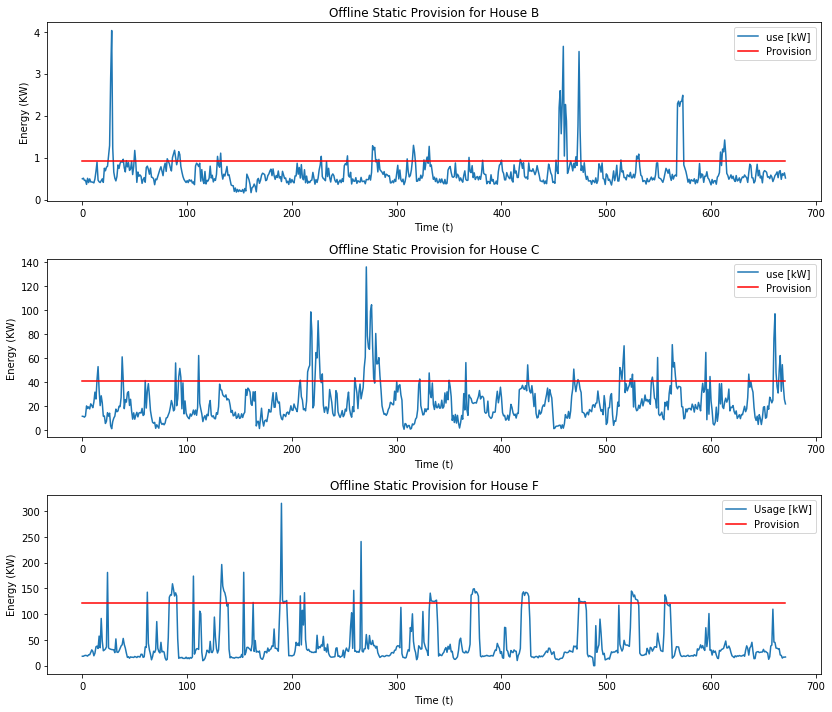

In [309]:
house_num=[]
os_cost=[]

def GetOfflineStaticCost(price,a,homepowerarr):
    provisionvar = cvxpy.Variable()
    localcost = 0
    
    # Cost Function
    for t in range(len(homepowerarr)):
        localcost += (price*provisionvar + a*cvxpy.maximum(0,homepowerarr[t]-provisionvar))
    
    objective = cvxpy.Minimize(localcost)
    prob = cvxpy.Problem(objective)
    result = prob.solve()
    return result,provisionvar.value

def staticOptimization(number,house,homepowerarr,homepowerdf, column):
    cost,provision = GetOfflineStaticCost(price,a,homepowerarr)
    house_num.append(house)
    os_cost.append(cost)
    provisionarr = np.full(672, provision)
    graphPlot(provisionarr,homepowerdf,column,number,0,"Offline Static Provision for House "+house)

fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=3, ncols=2)

staticOptimization(0,"B", homebpowerarr, homebpowerdf, "use [kW]")
staticOptimization(1,"C", homecpowerarr, homecpowerdf, "use [kW]")
staticOptimization(2,"F", homefpowerarr, homefpowerdf, "Usage [kW]")

plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])

comparison = pd.DataFrame({
    'House': house_num,
    'Cost': os_cost,
})

print("Optimal Offline Static Optimization")
display(comparison)

Since, this is a static optimization, we are getting a straight line on all the graphs

### 2. Offline Dynamic Optimization

The optimal value is calculated as:

$\sum \limits _{t=1} ^ {T} $price$*$provisionvar $+$ a$*$cvxpy.maximum(0,homepowerarr[t]-provisionvar) $+$b$*$abs(provisionvar[t]-provisionvar[t-1])

CVXPY is used to minimize the function for a provision variable. For, this minimized function, we are calculating the cost to achieve the final optimal value.

We get the below values after calculating the optimal offline dynamic optimization cost for all the houses:

Optimal Offline Dynamic Optimization


,House,Cost
0,B,160.471196
1,C,6674.851386
2,F,14744.553658


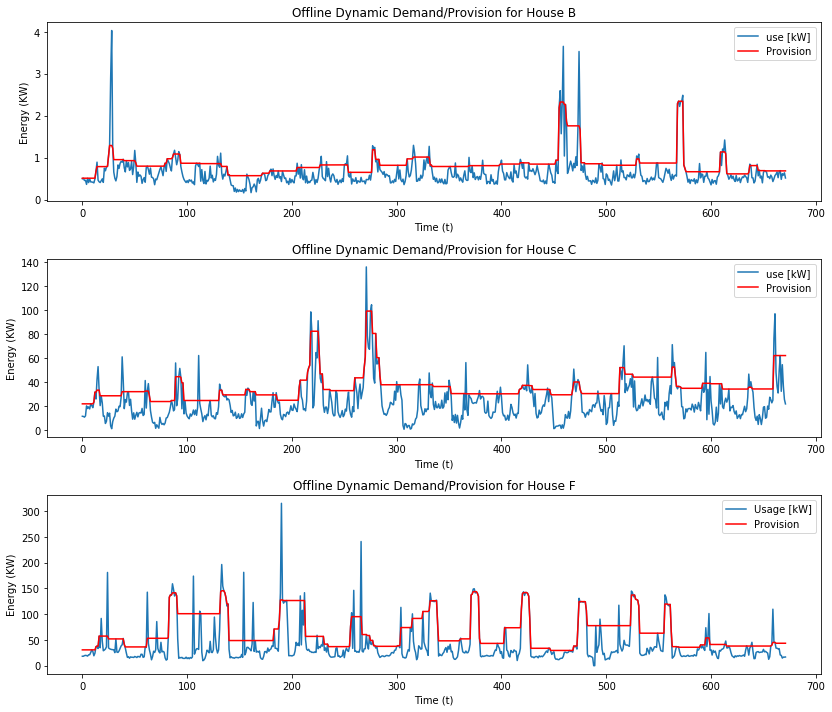

In [266]:
od_cost=[]

def GetOfflineDynamicCost(a,b,homepowerarr,price):
    provisionvar = cvxpy.Variable(len(homepowerarr))
    localcost=price*provisionvar[0] 
    
    # Cost function
    for t in range(1,len(homepowerarr)):
        localcost += (price*provisionvar[t] + a*cvxpy.maximum(0,homepowerarr[t]-provisionvar[t]) + b*abs(provisionvar[t]-provisionvar[t-1]))
    
    objective = cvxpy.Minimize(localcost)
    prob = cvxpy.Problem(objective)
    result = prob.solve()
    return result,provisionvar.value

def dynamicOptimization(number,house,homepowerarr,homepowerdf, column):
    cost,provision = GetOfflineDynamicCost(a,b,homepowerarr,price)
    od_cost.append(cost)
    graphPlot(provision,homepowerdf,column,number,0,"Offline Dynamic Provision for House "+house)

fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=3, ncols=2)

dynamicOptimization(0,"B", homebpowerarr, homebpowerdf, "use [kW]")
dynamicOptimization(1,"C", homecpowerarr, homecpowerdf, "use [kW]")
dynamicOptimization(2,"F", homefpowerarr, homefpowerdf, "Usage [kW]")

plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])

comparison = pd.DataFrame({
    'House': house_num,
    'Cost': od_cost,
})

print("Optimal Offline Dynamic Optimization")
display(comparison)

Since, this is a dynamic optimization, we are getting a boxed line on all the graphs.

### # Task 2. Try online gradient descent (with different step size), receding horizon control (with different prediction window size), commitment horizon control (with different commitment levels). For the latter two algorithms, use predictions from at least two prediction algorithms for the default value of a and b.

### Online Algorithms

As mentioned in the task, using online gradient descent (OGD) with varying step size, receding horizon control (RHC) with varying window size, commitment horizon control (CHC) with varying commitment levels. For RHC and CHC, used prediction data for Linear Regression and Random Forest from Assignment 1.

### 1. Online Gradient Decent

The optimal value is calculated as:

x[t+1] = x[t] - stepsize*(gradient)

At each iteration, the value of the observation is calculated as the difference between the previous observation and the partial diffrentiation of the objective function by x[t], i.e. gradient.

Step Size determined how much the value should be moved after finding the gradient at one point to help finding the best optimal value of the objective function. Step size is sometimes referred to as the learning rate.

##### For House B: Below are the values which we observe with varying step size as 0.0001, 0.001, 0.01, 0.1, 1

Online Gradient Descent: House B


,House,Step Size,Cost
0,B,0.0001,788.418407
1,B,0.001,379.768629
2,B,0.01,241.398313
3,B,0.1,480.256099
4,B,1,3318.054254


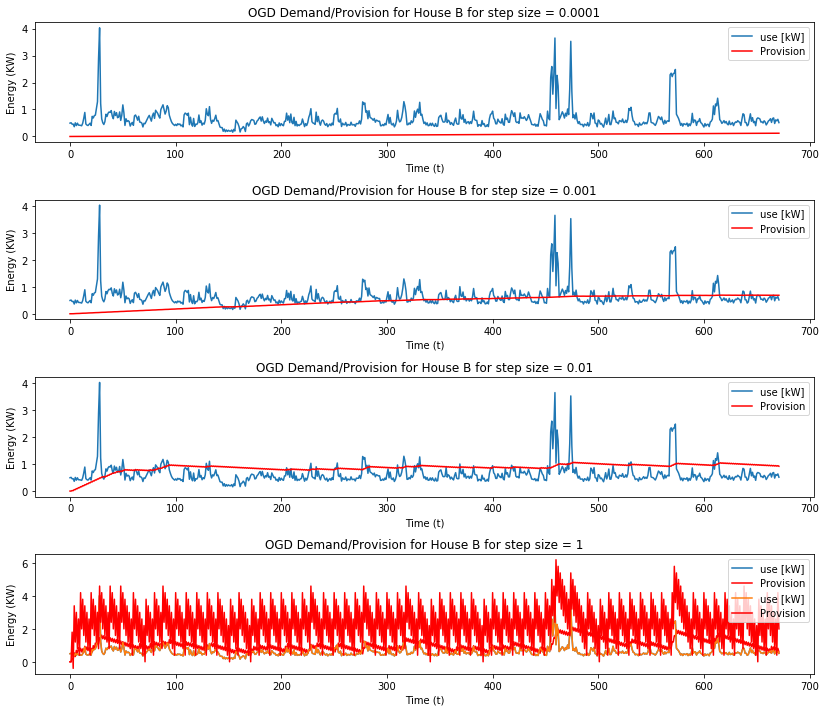

In [267]:
ogd_cost = []
o_house_type = []
step_size = []

def derivative(t,provision,homepowerarr,price):
    res = price
    if homepowerarr[t] > provision[t]:
        res = res-a
    if provision[t] < provision[t-1]:
        res=res-b
    elif provision[t] > provision[t-1]:
        res=res+b  
    return res

def OnlineGradientDescent(homepowerarr,step,price,a,b):
    provision = [0]*len(homepowerarr)
    for t in range(1,len(homepowerarr)-1):
        stepsize= step[t-1]
        gradient =derivative(t,provision,homepowerarr,price)
        provision[t+1] = provision[t] - stepsize*(gradient)
    return provision

def calcOGD(step, homepowerarr, homepowerdf, house, column, number):  
    
    stepsize = []
    for i in range (1,len(homebpowerarr)):
        stepsize.append(step)
    
    provision = OnlineGradientDescent(homepowerarr,stepsize,price,a,b)
    cost = FindCost(homepowerarr,provision,price,a,b)
    ogd_cost.append(cost)
    o_house_type.append(house)
    step_size.append(str(step))
    graphPlot(provision,homepowerdf,column,number,0,"OGD Provision for House "+house+" for step size = "+str(step))


fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=4, ncols=2)

#step size = 0.0001
calcOGD(0.0001, homebpowerarr, homebpowerdf, "B", "use [kW]", 0)

#step size = 0.001
calcOGD(0.001, homebpowerarr, homebpowerdf, "B", "use [kW]", 1)

#step size = 0.01
calcOGD(0.01, homebpowerarr, homebpowerdf, "B", "use [kW]", 2)

#step size = 0.1
calcOGD(0.1, homebpowerarr, homebpowerdf, "B", "use [kW]", 3)

#step size = 1
calcOGD(1, homebpowerarr, homebpowerdf, "B", "use [kW]", 3)

plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])

comparison = pd.DataFrame({
    'House': o_house_type,
    'Step Size': step_size,
    'Cost': ogd_cost,
})

print("Online Gradient Descent: House B")
display(comparison)

The last graph contains the values for both 0.1 and 1, just to show how the demand value looks with increasing values of step size.

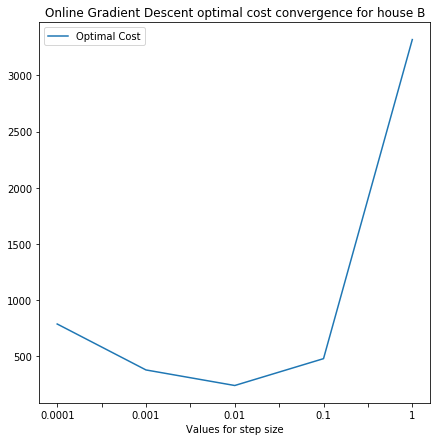

In [268]:
stepsizearr=["0.0001","0.001","0.01","0.1","1"]
ogddf = pd.DataFrame({
  'Values for step size': stepsizearr,
  'Optimal Cost': ogd_cost,
})
ogddf.plot.line(x='Values for step size', y='Optimal Cost',figsize=(7,7),title="Online Gradient Descent optimal cost convergence for house B")

#### For House B, we observe that the optimal value is achieved at 0.01 step size having cost as 241.398.

We can see that the above graph looks like a convex function having the global minimum at 0.01.

However, we can further tune our step sizes to caculate a more optimal cost with taking close differences from the above achieved step size i.e. 0.01. The graph gradually decreases to the global minimum and rises sharply after that.

##### For House C: Below are the values which we observe with varying step size as 0.0001, 0.001, 0.01, 0.1, 0.5, 1

Online Gradient Descent: House C


,House,Step Size,Cost
0,C,0.0001,31142.054593
1,C,0.001,30490.075333
2,C,0.01,24548.530467
3,C,0.1,11281.611500
4,C,0.5,9827.927567
5,C,1,10756.920800


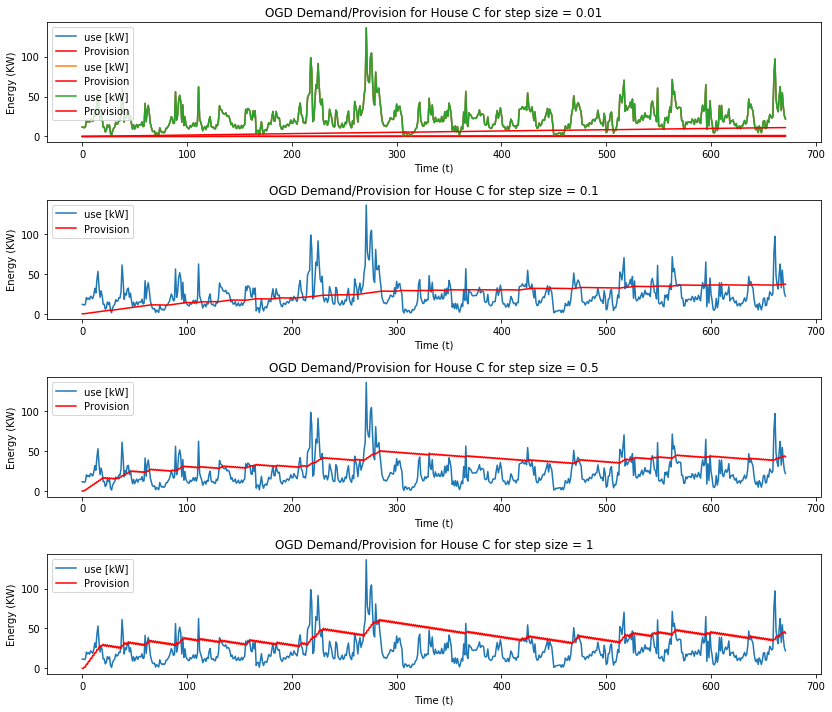

In [310]:
c_ogd_cost = []
o_house_type = []
step_size = []

def calcOGDC(step, homepowerarr, homepowerdf, house, column, number):  
    
    stepsize = []
    for i in range (1,len(homebpowerarr)):
        stepsize.append(step)
    
    provision = OnlineGradientDescent(homepowerarr,stepsize,price,a,b)
    cost = FindCost(homepowerarr,provision,price,a,b)
    c_ogd_cost.append(cost)
    o_house_type.append(house)
    step_size.append(str(step))
    graphPlot(provision,homepowerdf,column,number,0,"OGD Provision for House "+house+" for step size = "+str(step))

fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=4, ncols=2)

#step size = 0.0001
calcOGDC(0.0001, homecpowerarr, homecpowerdf, "C", "use [kW]", 0)

#step size = 0.001
calcOGDC(0.001, homecpowerarr, homecpowerdf, "C", "use [kW]", 0)

#step size = 0.01
calcOGDC(0.01, homecpowerarr, homecpowerdf, "C", "use [kW]", 0)

#step size = 0.1
calcOGDC(0.1, homecpowerarr, homecpowerdf, "C", "use [kW]", 1)

#step size = 0.5
calcOGDC(0.5, homecpowerarr, homecpowerdf, "C", "use [kW]", 2)

#step size = 1
calcOGDC(1, homecpowerarr, homecpowerdf, "C", "use [kW]", 3)

plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])

comparison = pd.DataFrame({
    'House': o_house_type,
    'Step Size': step_size,
    'Cost': c_ogd_cost,
})

print("Online Gradient Descent: House C")
display(comparison)

The first graph contains the values for 0.0001, 0.001 and 0.01, just to show how the demand value looks with lower values of step size for Home C.

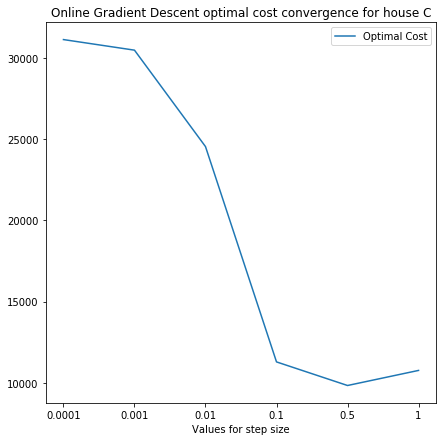

In [270]:
stepsizearr=["0.0001","0.001","0.01","0.1","0.5", "1"]
ogddf = pd.DataFrame({
  'Values for step size': stepsizearr,
  'Optimal Cost': c_ogd_cost,
})
ogddf.plot.line(x='Values for step size', y='Optimal Cost',figsize=(7,7),title="Online Gradient Descent optimal cost convergence for house C")

#### For House C, we observe that the optimal value is achieved at 0.5 step size having cost as 9827.927567

We can see that the above graph looks like a convex function having the global minimum at 0.5.

However, we can further tune our step sizes to caculate a more optimal cost with taking close differences from the above achieved step size i.e. 0.5. 

##### For House F: Below are the values which we observe with varying step size as 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9, 1, 2.5

Online Gradient Descent: House F


,House,Step Size,Cost
0,F,0.0001,57121.261260
1,F,0.001,56473.616400
2,F,0.01,49997.167800
3,F,0.1,29611.698700
4,F,0.5,24378.805267
5,F,0.9,23715.980733
6,F,1,23832.682333
7,F,2.5,25767.385900


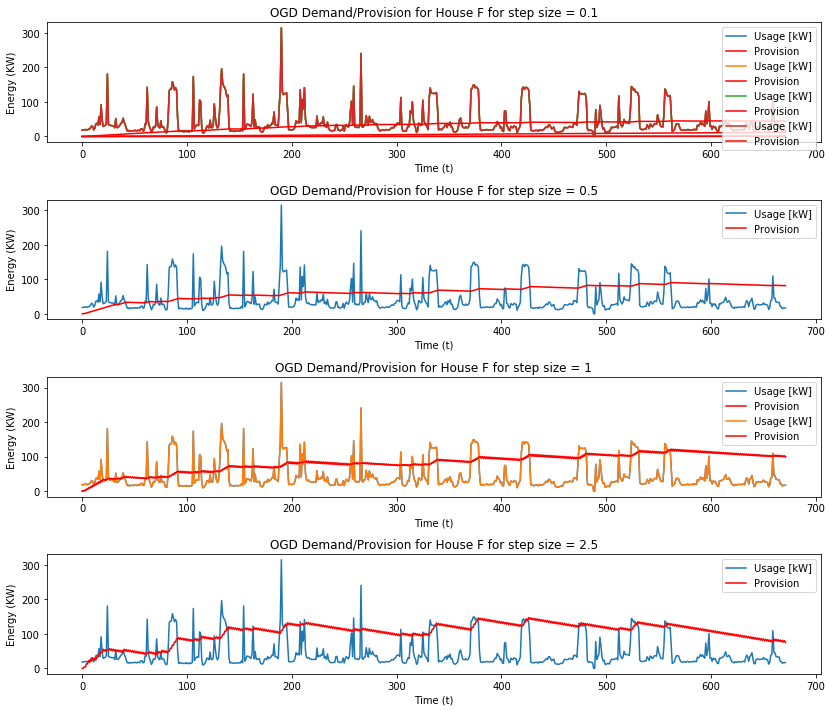

In [271]:
f_ogd_cost = []
o_house_type = []
step_size = []

def calcOGDF(step, homepowerarr, homepowerdf, house, column, number):  
    
    stepsize = []
    for i in range (1,len(homebpowerarr)):
        stepsize.append(step)
    
    provision = OnlineGradientDescent(homepowerarr,stepsize,price,a,b)
    cost = FindCost(homepowerarr,provision,price,a,b)
    f_ogd_cost.append(cost)
    o_house_type.append(house)
    step_size.append(str(step))
    graphPlot(provision,homepowerdf,column,number,0,"OGD Demand/Provision for House "+house+" for step size = "+str(step))

fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=4, ncols=2)

#step size = 0.0001
calcOGDF(0.0001, homefpowerarr, homefpowerdf, "F", "Usage [kW]", 0)

#step size = 0.001
calcOGDF(0.001, homefpowerarr, homefpowerdf, "F", "Usage [kW]", 0)

#step size = 0.01
calcOGDF(0.01, homefpowerarr, homefpowerdf, "F", "Usage [kW]", 0)

#step size = 0.1
calcOGDF(0.1, homefpowerarr, homefpowerdf, "F", "Usage [kW]", 0)

#step size = 0.5
calcOGDF(0.5, homefpowerarr, homefpowerdf, "F", "Usage [kW]", 1)

#step size = 0.9
calcOGDF(0.9, homefpowerarr, homefpowerdf, "F", "Usage [kW]", 2)

#step size = 1
calcOGDF(1, homefpowerarr, homefpowerdf, "F", "Usage [kW]", 2)

#step size = 2.5
calcOGDF(2.5, homefpowerarr, homefpowerdf, "F", "Usage [kW]", 3)

plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])

comparison = pd.DataFrame({
    'House': o_house_type,
    'Step Size': step_size,
    'Cost': f_ogd_cost,
})

print("Online Gradient Descent: House F")
display(comparison)

The first graph contains the values for 0.0001, 0.001, 0.01 and 0.1, just to show how the demand value looks with lower values of step size for Home F.

The third graph contains values for 0.9 and 1 step size to show that demand value looks almost same when the differnces are near and we are close to finding the global minimum.

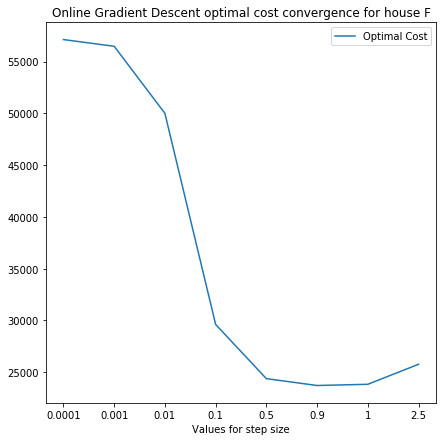

In [272]:
stepsizearr=["0.0001","0.001","0.01","0.1","0.5", "0.9","1","2.5"]
ogddf = pd.DataFrame({
  'Values for step size': stepsizearr,
  'Optimal Cost': f_ogd_cost,
})
ogddf.plot.line(x='Values for step size', y='Optimal Cost',figsize=(7,7),title="Online Gradient Descent optimal cost convergence for house F")

#### For House C, we observe that the optimal value is achieved at 0.9 step size having cost as 23715.980733

We can see that the above graph looks like a convex function having the global minimum at 0.9.

However, we can further tune our step sizes to caculate a more optimal cost with taking close differences from the above achieved step size i.e. 0.9. 

### 2. Receding Horizon Control

Receding Horizon Control is also known as Model predictive control. Practical examples of the algorithm includes automated/ self driving cars where it needs to cacluate real time, for instance, angle of the steering movement to control the turning of the car depending on its speed and obstacles ahead.

The optimal value is calculated as:

$\sum \limits _{i=1} ^ {I} $price$*$x_window[i] $+$ a$*$cvxpy.maximum(0,y_window[i]-x_window[i]) + b$*$abs(x_window[i]-x_window[i-1])

CVXPY is used to minimize the function for a provision variable. For, this minimized function, we are calculating the cost to achieve the final optimal value. Here x_window is the window of the actual observations, y_window is the window of the predicted values from Linear Regression and Random Forest obtained from assignment 1.

We are using different window sizes to find the optimal cost of the objective function. A general observation which was found that for smaller window sizes, there was not much difference. Optimal cost increased when increasing the window size. However, we cannot increase the window size too much as it will not account for events in the future.

In [273]:
def GetRHC(a,b,y_pred,window,price):
    x_optimal = [0]*672
    for t in range(1,672):
        if(t>=len(y_pred)):
            break
        localcost = 0
        y_window = y_pred[t:t+window]
        x_window = cvxpy.Variable(window)
        
        for i in range(len(y_window)):
            localcost += (price*x_window[i] + a*cvxpy.maximum(0,y_window[i]-x_window[i]) + b*abs(x_window[i]-x_window[i-1]))  
            
        constraints = [x_window >= 0]  
        obj = cvxpy.Minimize(localcost)
        prob = cvxpy.Problem(obj, constraints)
        prob.solve()
        x_optimal[t] = x_window.value[0]
    return x_optimal

Window size determines the length of the timeframe to find local minimum for that particular timeframe. After iterating through all the smaller timeframes, we find a set of local minimums to eventually find the best global minimum and optimal value of the objective function. 

##### For House B: Below are the values which we observe with varying window size as 5, 10, 15, 20, 25, 30 for Linear Regression

Cost of House B using RHC and Linear Regression for window size =  5  is  244.24407087637803
Cost of House B using RHC and Linear Regression for window size =  10  is  231.20159288973147
Cost of House B using RHC and Linear Regression for window size =  15  is  228.66815943200973
Cost of House B using RHC and Linear Regression for window size =  20  is  225.6266024510253
Cost of House B using RHC and Linear Regression for window size =  25  is  227.8941536172688
Cost of House B using RHC and Linear Regression for window size =  30  is  226.03379352797668


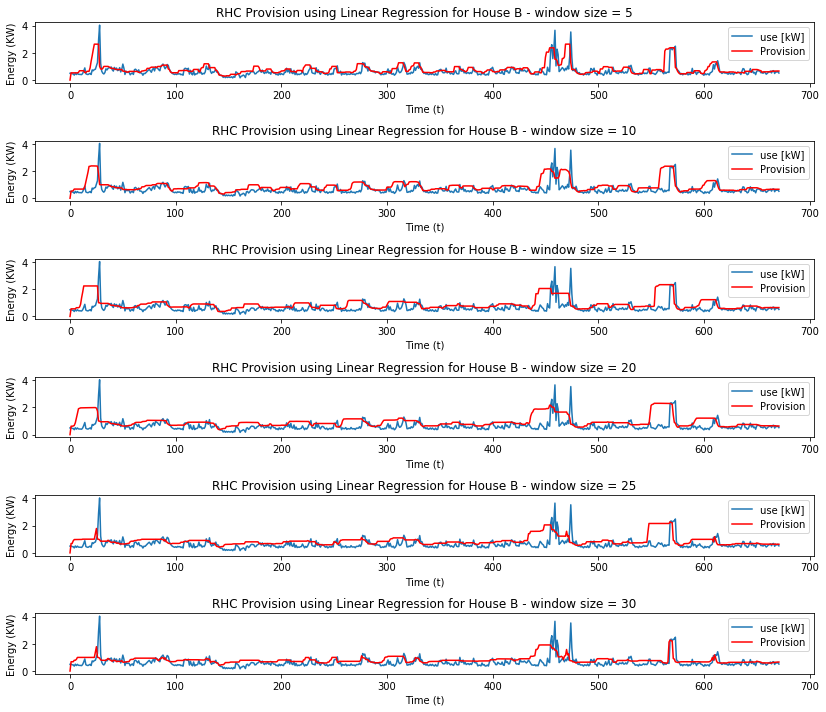

In [275]:
o_house_type = []
pred_alg = []
b_rhc_cost = []

fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=6, ncols=2)

predwindowsize = [5,10,15,20,25,30]
number = 0

homeblrpreddfarr = np.asarray(homeblrpreddf)
for window in predwindowsize:
    provision = GetRHC(a,b,homeblrpreddfarr,window,price)
    cost = getCost(homebpowerarr,provision,price,a,b)
    print("Cost of House B using RHC and Linear Regression for window size = ",window," is ",cost)
    o_house_type.append('B')
    pred_alg.append("Linear Regression")
    b_rhc_cost.append(cost)
    titlestr = "RHC Provision using Linear Regression for House B - window size = " + str(window)
    graphPlot(provision,homebpowerdf,"use [kW]",number,0,titlestr)
    number = number + 1
    
plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])
fig.delaxes(axes[4][1])
fig.delaxes(axes[5][1])

##### For House B: Below are the values which we observe with varying window size as 5, 10, 15, 20, 25, 30 for Random Forest

Cost of House B using RHC and Random Forest for window size =  5  is  247.68722421050907
Cost of House B using RHC and Random Forest for window size =  10  is  235.0044714748754
Cost of House B using RHC and Random Forest for window size =  15  is  236.02810225245432
Cost of House B using RHC and Random Forest for window size =  20  is  220.43900863283463
Cost of House B using RHC and Random Forest for window size =  25  is  231.10999944840023
Cost of House B using RHC and Random Forest for window size =  30  is  229.92313484873102
Receding Horizon Control: House B


,House,Prediction Algorithm,Window Size,Cost
0,B,Linear Regression,5,244.244071
1,B,Linear Regression,10,231.201593
2,B,Linear Regression,15,228.668159
3,B,Linear Regression,20,225.626602
4,B,Linear Regression,25,227.894154
5,B,Linear Regression,30,226.033794
6,B,Random Forest,5,247.687224
7,B,Random Forest,10,235.004471
8,B,Random Forest,15,236.028102
9,B,Random Forest,20,220.439009


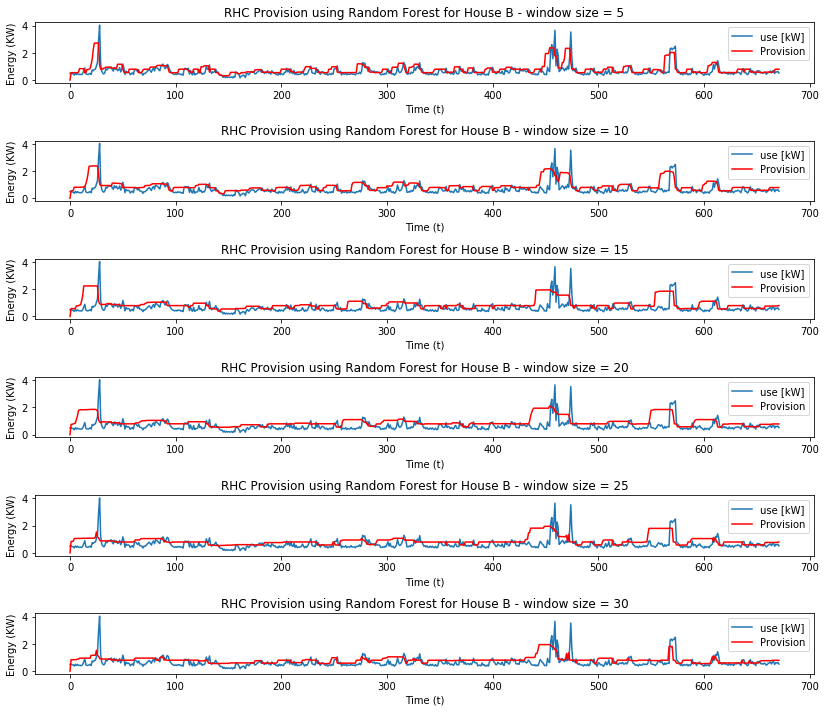

In [276]:
fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=6, ncols=2)

number = 0

predwindowsizes = [5,10,15,20,25,30]

homebrfpreddfarr = np.asarray(homebrfpreddf)
for window in predwindowsizes:
    provision = GetRHC(a,b,homebrfpreddfarr,window,price)
    cost = getCost(homebpowerarr,provision,price,a,b)
    print("Cost of House B using RHC and Random Forest for window size = ",window," is ",cost)
    o_house_type.append('B')
    pred_alg.append("Random Forest")
    predwindowsize.append(window)
    b_rhc_cost.append(cost)
    titlestr = "RHC Provision using Random Forest for House B - window size = " + str(window)
    graphPlot(provision,homebpowerdf,"use [kW]",number,0,titlestr)
    number = number + 1
    
plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])
fig.delaxes(axes[4][1])
fig.delaxes(axes[5][1])

comparison = pd.DataFrame({
    'House': o_house_type,
    'Prediction Algorithm': pred_alg,
    'Window Size': predwindowsize,
    'Cost' : b_rhc_cost,
})

print("Receding Horizon Control: House B")
display(comparison)

### For House B, we observe that the optimal value is achieved at 20 window size for Random Forest having cost as 220.439009

##### For House C: Below are the values which we observe with varying window size as 5, 10, 15, 20, 25, 30 for Linear Regression

Cost of House C using RHC and Linear Regression for window size =  5  is  8749.76931772975
Cost of House C using RHC and Linear Regression for window size =  10  is  8690.727184681362
Cost of House C using RHC and Linear Regression for window size =  15  is  8657.602876088642
Cost of House C using RHC and Linear Regression for window size =  20  is  8542.57905729654
Cost of House C using RHC and Linear Regression for window size =  25  is  8497.530249713845
Cost of House C using RHC and Linear Regression for window size =  30  is  8544.938909973425


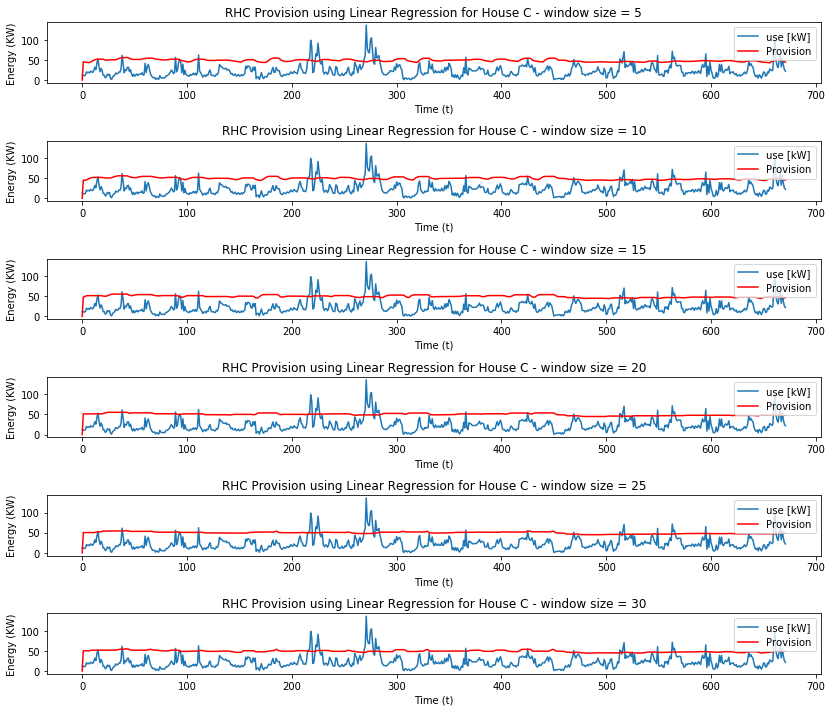

In [277]:
o_house_type = []
pred_alg = []
c_rhc_cost = []

fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=6, ncols=2)

predwindowsize = [5,10,15,20,25,30]
number = 0

homeclrpreddfarr = np.asarray(homeclrpreddf)
for window in predwindowsize:
    provision = GetRHC(a,b,homeclrpreddfarr,window,price)
    cost = getCost(homecpowerarr,provision,price,a,b)
    print("Cost of House C using RHC and Linear Regression for window size = ",window," is ",cost)
    o_house_type.append('C')
    pred_alg.append("Linear Regression")
    c_rhc_cost.append(cost)
    titlestr = "RHC Provision using Linear Regression for House C - window size = " + str(window)
    graphPlot(provision,homecpowerdf,"use [kW]",number,0,titlestr)
    number = number + 1
    
plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])
fig.delaxes(axes[4][1])
fig.delaxes(axes[5][1])

##### For House C: Below are the values which we observe with varying window size as 5, 10, 15, 20, 25, 30 for Random Forest

Cost of House C using RHC and Random Forest for window size =  5  is  9418.748062791476
Cost of House C using RHC and Random Forest for window size =  10  is  9003.641108235648
Cost of House C using RHC and Random Forest for window size =  15  is  8731.775920813187
Cost of House C using RHC and Random Forest for window size =  20  is  8649.80754594962
Cost of House C using RHC and Random Forest for window size =  25  is  8649.660768148186
Cost of House C using RHC and Random Forest for window size =  30  is  8776.287977054975
Receding Horizon Control: House B


,House,Prediction Algorithm,Window Size,Cost
0,C,Linear Regression,5,8749.769318
1,C,Linear Regression,10,8690.727185
2,C,Linear Regression,15,8657.602876
3,C,Linear Regression,20,8542.579057
4,C,Linear Regression,25,8497.530250
5,C,Linear Regression,30,8544.938910
6,C,Random Forest,5,9418.748063
7,C,Random Forest,10,9003.641108
8,C,Random Forest,15,8731.775921
9,C,Random Forest,20,8649.807546


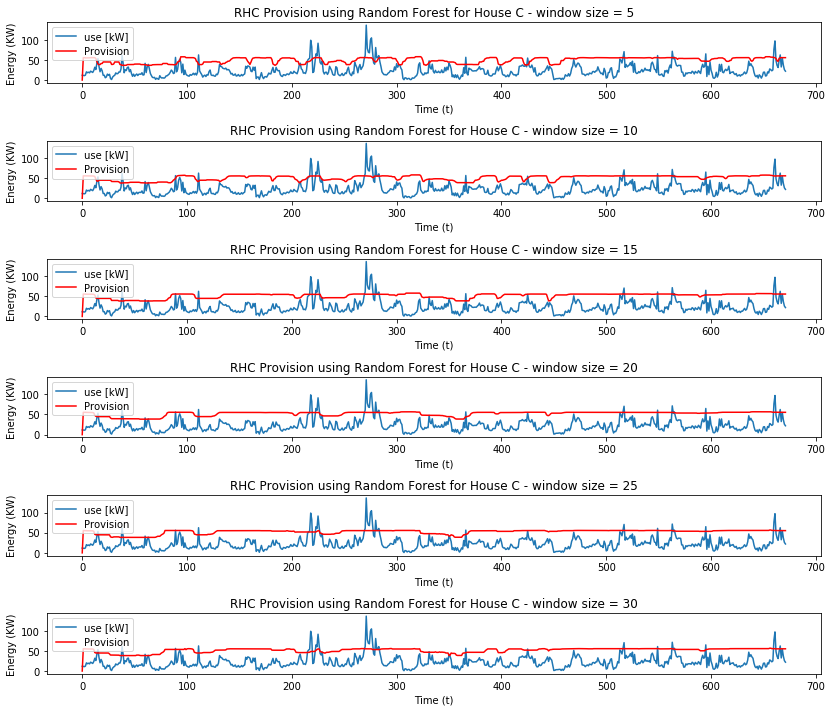

In [278]:
fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=6, ncols=2)

number = 0

predwindows = [5,10,15,20,25,30]

homecrfpreddfarr = np.asarray(homecrfpreddf)
for window in predwindows:
    provision = GetRHC(a,b,homecrfpreddfarr,window,price)
    cost = getCost(homecpowerarr,provision,price,a,b)
    print("Cost of House C using RHC and Random Forest for window size = ",window," is ",cost)
    o_house_type.append('C')
    pred_alg.append("Random Forest")
    predwindowsize.append(window)
    c_rhc_cost.append(cost)
    titlestr = "RHC Provision using Random Forest for House C - window size = " + str(window)
    graphPlot(provision,homecpowerdf,"use [kW]",number,0,titlestr)
    number = number + 1
    
plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])
fig.delaxes(axes[4][1])
fig.delaxes(axes[5][1])

comparison = pd.DataFrame({
    'House': o_house_type,
    'Prediction Algorithm': pred_alg,
    'Window Size': predwindowsize,
    'Cost' : c_rhc_cost,
})

print("Receding Horizon Control: House B")
display(comparison)

### For House C, we observe that the optimal value is achieved at 25 window size for Linear Regression having cost as 8497.530250

##### For House F: Below are the values which we observe with varying window size as 5, 10, 15, 20, 25, 30 for Linear Regression

Cost of House F using RHC and Linear Regression for window size =  5  is  23401.582411930234
Cost of House F using RHC and Linear Regression for window size =  10  is  23179.573882357756
Cost of House F using RHC and Linear Regression for window size =  15  is  22927.60516159148
Cost of House F using RHC and Linear Regression for window size =  20  is  23196.806885617876
Cost of House F using RHC and Linear Regression for window size =  25  is  22873.88339065877
Cost of House F using RHC and Linear Regression for window size =  30  is  21999.434488828105


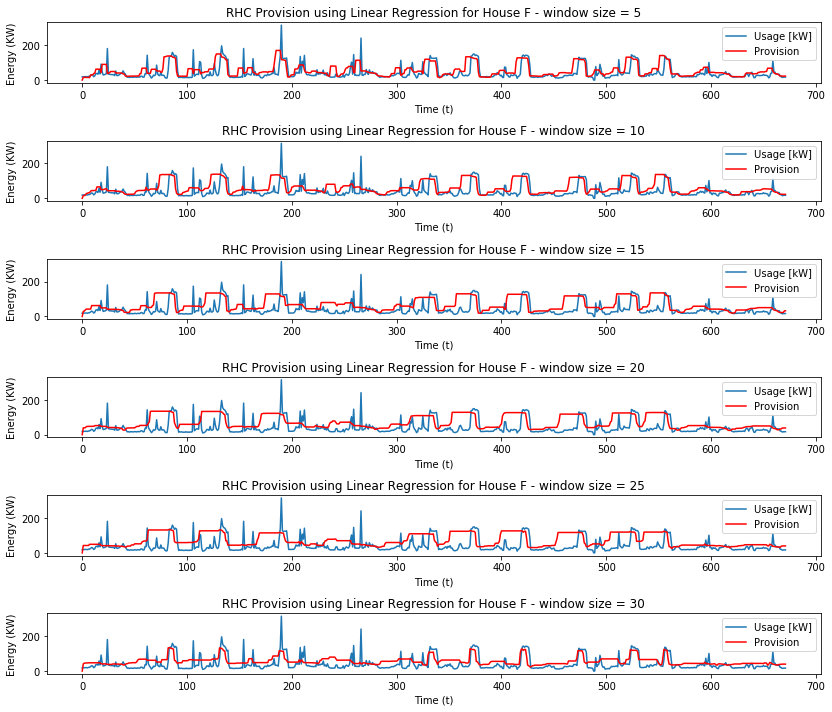

In [279]:
o_house_type = []
pred_alg = []
f_rhc_cost = []

fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=6, ncols=2)

predwindowsize = [5,10,15,20,25,30]
number = 0

homeflrpreddfarr = np.asarray(homeflrpreddf)
for window in predwindowsize:
    provision = GetRHC(a,b,homeflrpreddfarr,window,price)
    cost = getCost(homefpowerarr,provision,price,a,b)
    print("Cost of House F using RHC and Linear Regression for window size = ",window," is ",cost)
    o_house_type.append('F')
    pred_alg.append("Linear Regression")
    f_rhc_cost.append(cost)
    titlestr = "RHC Provision using Linear Regression for House F - window size = " + str(window)
    graphPlot(provision,homefpowerdf,"Usage [kW]",number,0,titlestr)
    number = number + 1
    
plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])
fig.delaxes(axes[4][1])
fig.delaxes(axes[5][1])

##### For House F: Below are the values which we observe with varying window size as 5, 10, 15, 20, 25, 30 for Random Forest

Cost of House F using RHC and Random Forest for window size =  5  is  22670.93579465478
Cost of House F using RHC and Random Forest for window size =  10  is  23339.201074729255
Cost of House F using RHC and Random Forest for window size =  15  is  22980.530330711576
Cost of House F using RHC and Random Forest for window size =  20  is  23028.023850462465
Cost of House F using RHC and Random Forest for window size =  25  is  22827.291037408242
Cost of House F using RHC and Random Forest for window size =  30  is  21493.746005298344
Receding Horizon Control: House B


,House,Prediction Algorithm,Window Size,Cost
0,F,Linear Regression,5,23401.582412
1,F,Linear Regression,10,23179.573882
2,F,Linear Regression,15,22927.605162
3,F,Linear Regression,20,23196.806886
4,F,Linear Regression,25,22873.883391
5,F,Linear Regression,30,21999.434489
6,F,Random Forest,5,22670.935795
7,F,Random Forest,10,23339.201075
8,F,Random Forest,15,22980.530331
9,F,Random Forest,20,23028.023850


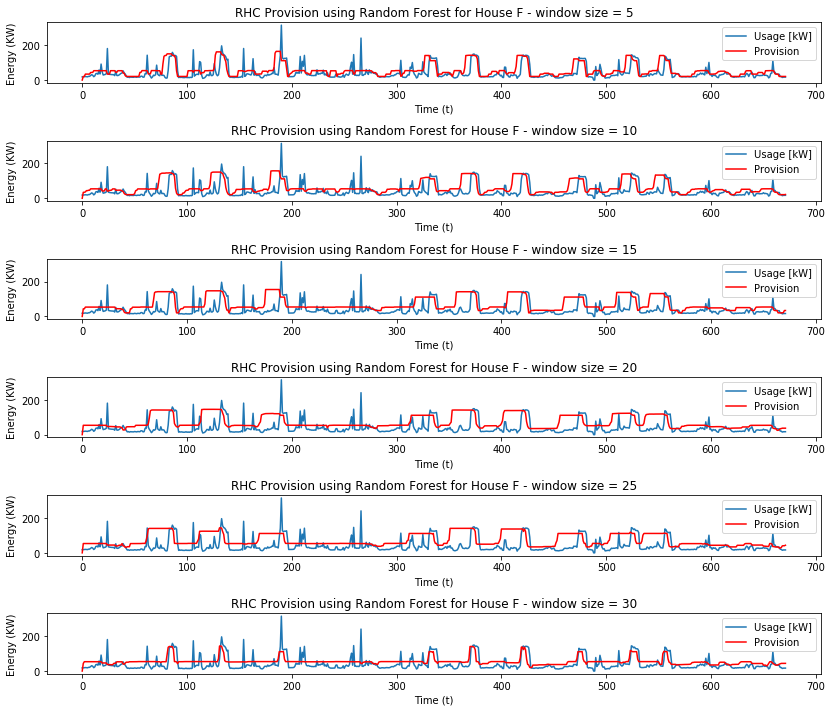

In [280]:
fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=6, ncols=2)

number = 0

predwindows = [5,10,15,20,25,30]

homefrfpreddfarr = np.asarray(homefrfpreddf)
for window in predwindows:
    provision = GetRHC(a,b,homefrfpreddfarr,window,price)
    cost = getCost(homefpowerarr,provision,price,a,b)
    print("Cost of House F using RHC and Random Forest for window size = ",window," is ",cost)
    o_house_type.append('F')
    pred_alg.append("Random Forest")
    predwindowsize.append(window)
    f_rhc_cost.append(cost)
    titlestr = "RHC Provision using Random Forest for House F - window size = " + str(window)
    graphPlot(provision,homefpowerdf,"Usage [kW]",number,0,titlestr)
    number = number + 1
    
plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])
fig.delaxes(axes[4][1])
fig.delaxes(axes[5][1])

comparison = pd.DataFrame({
    'House': o_house_type,
    'Prediction Algorithm': pred_alg,
    'Window Size': predwindowsize,
    'Cost' : f_rhc_cost,
})

print("Receding Horizon Control: House B")
display(comparison)

### For House F, we observe that the optimal value is achieved at 30 window size for Random Forest having cost as 21493.746005

### 3. Commitment Horizon Control

The optimal value is calculated as:

$\sum \limits _{i=1} ^ {I} $price$*$x_optimal[i] + a$*$maximum(0,y_window[i]-x_optimal[i]) + b$*$abs(x_optimal[i]-x_optimal[i-1])

CVXPY is used to minimize the function for a provision variable. For, this minimized function, we are calculating the cost to achieve the final optimal value. 

As it is build on top of RHC, x_window and y_window is the window of the predicted values from Linear Regression and Random Forest obtained from assignment 1 and are set to 25 for all the houses as optimal cost using RHC was obtained between 20 to 30 in the above runs. Commitment horizon values are varied to find the optimal cost of the CHC objective function.

Commitment Horizon values used in this assignment are 1,3,5 and 10.

In [281]:
def GetCHC(a,b,y_pred,window,commitmenthorizon,price):
    x = [0]*672
    for t in range(1,672):
        if(t>=len(y_pred)):
            break
        x_optimal = cvxpy.Variable(window)
        y_window = y_pred[t:t+window]
        localcost = 0
        for i in range(len(y_window)):
            localcost += (price*x_optimal[i] + a*maximum(0,y_window[i]-x_optimal[i]) + b*abs(x_optimal[i]-x_optimal[i-1]))
        constraints = [x_optimal >= 0]
        obj = cvxpy.Minimize(localcost)
        prob = cvxpy.Problem(obj, constraints)
        prob.solve()
        for c in range(commitmenthorizon):
            index = t+c
            if index < 672:
                x[index] = x[index] + x_optimal.value[c]
    for i in range(1,672):
        x[i] = x[i]/commitmenthorizon
    return x

##### For House B: Below are the values which we observe with varying commitment horizon values as 1, 3, 5 and 10 for Linear Regression

Cost of House B using CHC and Linear Regression for commitment =  1  is  227.8941536172688
Cost of House B using CHC and Linear Regression for commitment =  3  is  213.49840394575287
Cost of House B using CHC and Linear Regression for commitment =  5  is  207.545061010842
Cost of House B using CHC and Linear Regression for commitment =  10  is  198.80474790083844


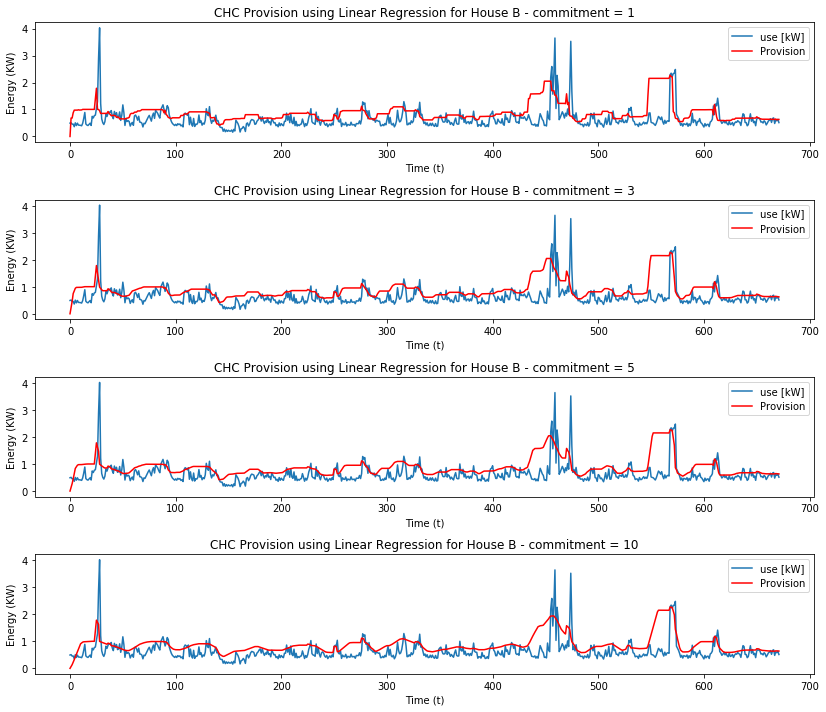

In [311]:
o_house_type = []
pred_alg = []
b_chc_cost = []

fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=4, ncols=2)

commitmenthorizon = [1,3,5,10]
window = 25
number = 0

for commitment in commitmenthorizon:
    provision = GetCHC(a,b,homeblrpreddfarr,window,commitment,price)
    cost = getCost(homebpowerarr,provision,price,a,b)
    print("Cost of House B using CHC and Linear Regression for commitment = ",commitment," is ",cost)
    o_house_type.append('B')
    pred_alg.append("Linear Regression")
    b_chc_cost.append(cost)
    titlestr = "CHC Provision using Linear Regression for House B - commitment = " + str(commitment)
    graphPlot(provision,homebpowerdf,"use [kW]",number,0,titlestr)
    number = number + 1
    
plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])

##### For House B: Below are the values which we observe with varying commitment horizon values as 1, 3, 5 and 10 for Random Forest

Cost of House B using CHC and Random Forest for commitment =  1  is  231.10999944840023
Cost of House B using CHC and Random Forest for commitment =  3  is  214.344960137594
Cost of House B using CHC and Random Forest for commitment =  5  is  207.7899342507709
Cost of House B using CHC and Random Forest for commitment =  10  is  197.8747763977131
Commitment Horizon Control: House B


,House,Prediction Algorithm,Commitment Level,Cost
0,B,Linear Regression,1,227.894154
1,B,Linear Regression,3,213.498404
2,B,Linear Regression,5,207.545061
3,B,Linear Regression,10,198.804748
4,B,Random Forest,1,231.109999
5,B,Random Forest,3,214.344960
6,B,Random Forest,5,207.789934
7,B,Random Forest,10,197.874776


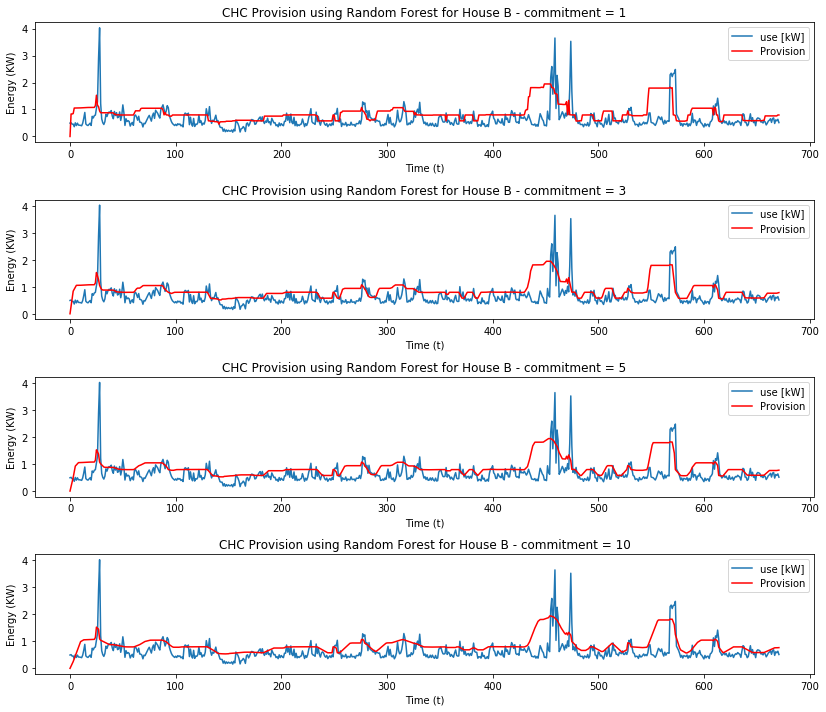

In [312]:
fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=4, ncols=2)

commitmenthorizons = [1,3,5,10]
window = 25
number = 0

for commitment in commitmenthorizons:
    provision = GetCHC(a,b,homebrfpreddfarr,window,commitment,price)
    cost = getCost(homebpowerarr,provision,price,a,b)
    print("Cost of House B using CHC and Random Forest for commitment = ",commitment," is ",cost)
    o_house_type.append('B')
    pred_alg.append("Random Forest")
    b_chc_cost.append(cost)
    commitmenthorizon.append(commitment)
    titlestr = "CHC Provision using Random Forest for House B - commitment = " + str(commitment)
    graphPlot(provision,homebpowerdf,"use [kW]",number,0,titlestr)
    number = number + 1
    
plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])

comparison = pd.DataFrame({
    'House': o_house_type,
    'Prediction Algorithm': pred_alg,
    'Commitment Level': commitmenthorizon,
    'Cost' : b_chc_cost,
})

print("Commitment Horizon Control: House B")
display(comparison)

### For House B, we observe that the optimal value is achieved at 10 commitment horizon value for Random Forest having cost as 197.874776

##### For House C: Below are the values which we observe with varying commitment horizon value as 1, 3, 5 and 10 for Linear Regression

Cost of House C using CHC and Linear Regression for commitment =  1  is  8497.530249713845
Cost of House C using CHC and Linear Regression for commitment =  3  is  8487.319136856338
Cost of House C using CHC and Linear Regression for commitment =  5  is  8477.817160494846
Cost of House C using CHC and Linear Regression for commitment =  10  is  8467.972863847368


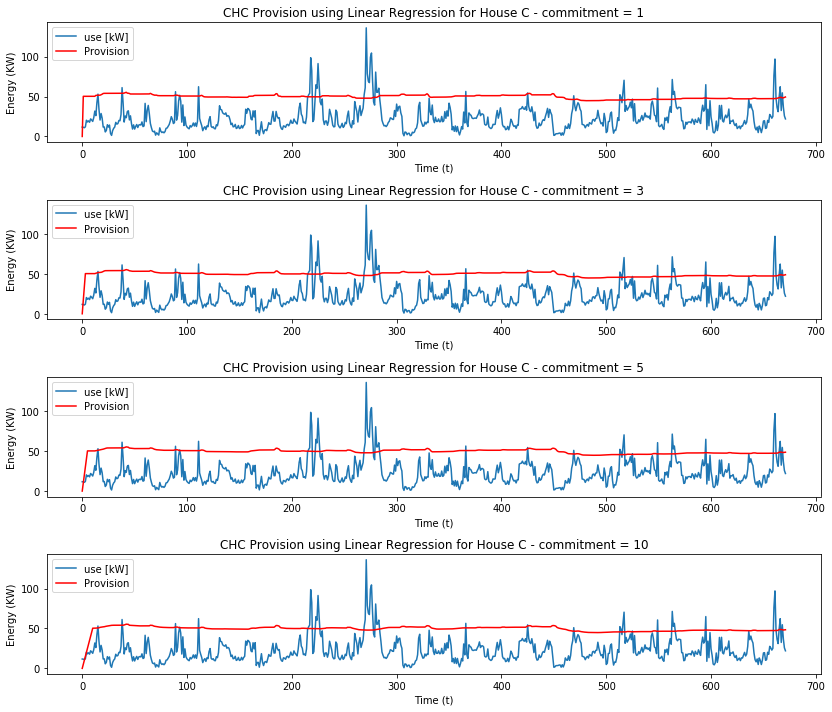

In [313]:
o_house_type = []
pred_alg = []
c_chc_cost = []

fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=4, ncols=2)

commitmenthorizon = [1,3,5,10]
window = 25
number = 0

for commitment in commitmenthorizon:
    provision = GetCHC(a,b,homeclrpreddfarr,window,commitment,price)
    cost = getCost(homecpowerarr,provision,price,a,b)
    print("Cost of House C using CHC and Linear Regression for commitment = ",commitment," is ",cost)
    o_house_type.append('C')
    pred_alg.append("Linear Regression")
    c_chc_cost.append(cost)
    titlestr = "CHC Provision using Linear Regression for House C - commitment = " + str(commitment)
    graphPlot(provision,homecpowerdf,"use [kW]",number,0,titlestr)
    number = number + 1
    
plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])

##### For House C: Below are the values which we observe with varying commitment horizon values as 1, 3, 5 and 10 for Random Forest

Cost of House C using CHC and Random Forest for commitment =  1  is  8649.660768148186
Cost of House C using CHC and Random Forest for commitment =  3  is  8624.280986421063
Cost of House C using CHC and Random Forest for commitment =  5  is  8600.560303296981
Cost of House C using CHC and Random Forest for commitment =  10  is  8554.05733571515
Commitment Horizon Control: House C


,House,Prediction Algorithm,Commitment Level,Cost
0,C,Linear Regression,1,8497.530250
1,C,Linear Regression,3,8487.319137
2,C,Linear Regression,5,8477.817160
3,C,Linear Regression,10,8467.972864
4,C,Random Forest,1,8649.660768
5,C,Random Forest,3,8624.280986
6,C,Random Forest,5,8600.560303
7,C,Random Forest,10,8554.057336


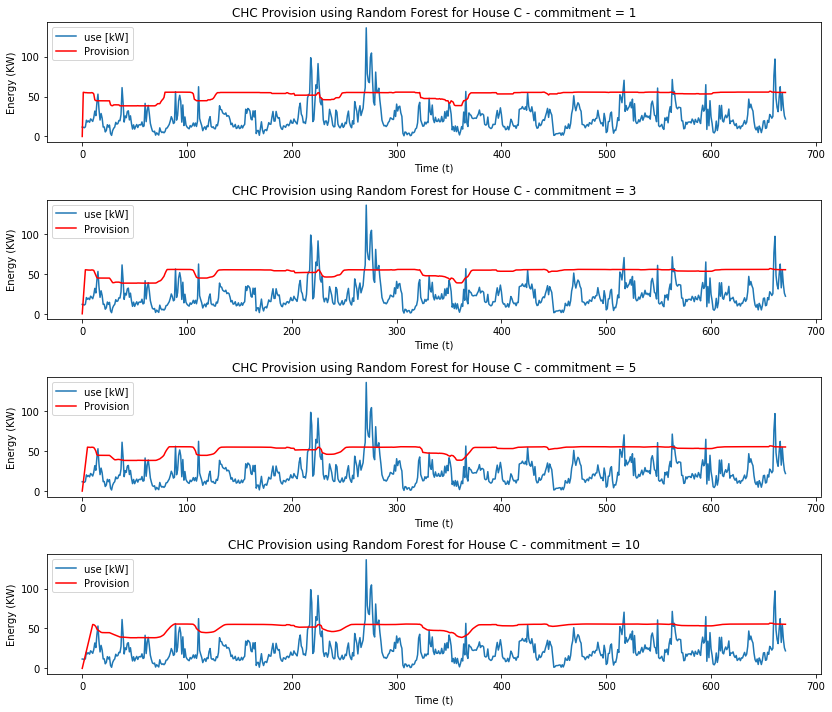

In [314]:
fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=4, ncols=2)

commitmenthorizons = [1,3,5,10]
window = 25
number = 0

for commitment in commitmenthorizons:
    provision = GetCHC(a,b,homecrfpreddfarr,window,commitment,price)
    cost = getCost(homecpowerarr,provision,price,a,b)
    print("Cost of House C using CHC and Random Forest for commitment = ",commitment," is ",cost)
    o_house_type.append('C')
    pred_alg.append("Random Forest")
    c_chc_cost.append(cost)
    commitmenthorizon.append(commitment)
    titlestr = "CHC Provision using Random Forest for House C - commitment = " + str(commitment)
    graphPlot(provision,homecpowerdf,"use [kW]",number,0,titlestr)
    number = number + 1
    
plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])

comparison = pd.DataFrame({
    'House': o_house_type,
    'Prediction Algorithm': pred_alg,
    'Commitment Level': commitmenthorizon,
    'Cost' : c_chc_cost,
})

print("Commitment Horizon Control: House C")
display(comparison)

### For House C, we observe that the optimal value is achieved at 10 commitment horizon value for Linear Regression having cost as 8467.972864

##### For House F: Below are the values which we observe with varying commitment horizon value as 1, 3, 5 and 10 for Linear Regression

Cost of House F using CHC and Linear Regression for commitment =  1  is  22873.88339065877
Cost of House F using CHC and Linear Regression for commitment =  3  is  21199.034390953784
Cost of House F using CHC and Linear Regression for commitment =  5  is  20462.879972444982
Cost of House F using CHC and Linear Regression for commitment =  10  is  19173.387383251713


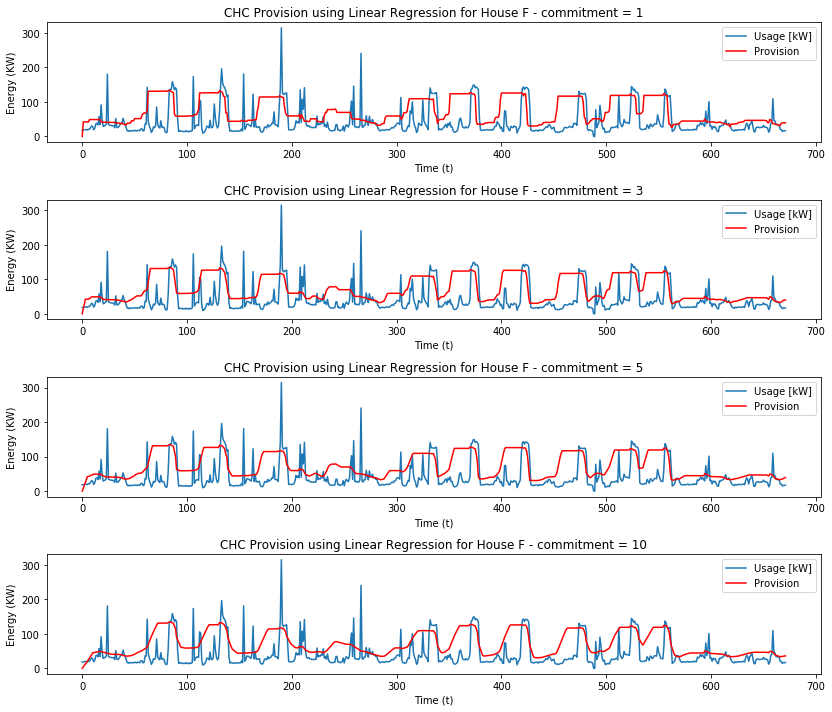

In [317]:
o_house_type = []
pred_alg = []
f_chc_cost = []

fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=4, ncols=2)

commitmenthorizon = [1,3,5,10]
window = 25
number = 0

for commitment in commitmenthorizon:
    provision = GetCHC(a,b,homeflrpreddfarr,window,commitment,price)
    cost = getCost(homefpowerarr,provision,price,a,b)
    print("Cost of House F using CHC and Linear Regression for commitment = ",commitment," is ",cost)
    o_house_type.append('F')
    pred_alg.append("Linear Regression")
    f_chc_cost.append(cost)
    titlestr = "CHC Provision using Linear Regression for House F - commitment = " + str(commitment)
    graphPlot(provision,homefpowerdf,"Usage [kW]",number,0,titlestr)
    number = number + 1
    
plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])

##### For House F: Below are the values which we observe with varying commitment horizon values as 1, 3, 5 and 10 for Random Forest

Cost of House F using CHC and Random Forest for commitment =  1  is  22827.291037408242
Cost of House F using CHC and Random Forest for commitment =  3  is  21273.923881436895
Cost of House F using CHC and Random Forest for commitment =  5  is  20612.63338044706
Cost of House F using CHC and Random Forest for commitment =  10  is  19224.51048644486
Commitment Horizon Control: House F


,House,Prediction Algorithm,Commitment Level,Cost
0,F,Linear Regression,1,22873.883391
1,F,Linear Regression,3,21199.034391
2,F,Linear Regression,5,20462.879972
3,F,Linear Regression,10,19173.387383
4,F,Random Forest,1,22827.291037
5,F,Random Forest,3,21273.923881
6,F,Random Forest,5,20612.633380
7,F,Random Forest,10,19224.510486


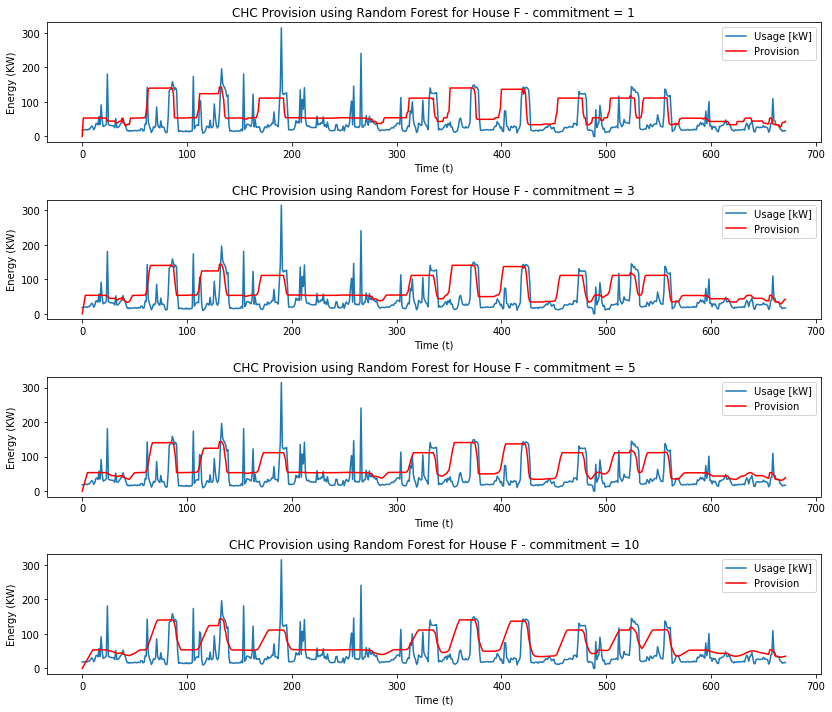

In [318]:
fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=4, ncols=2)

commitmenthorizons = [1,3,5,10]
window = 25
number = 0

for commitment in commitmenthorizons:
    provision = GetCHC(a,b,homefrfpreddfarr,window,commitment,price)
    cost = getCost(homefpowerarr,provision,price,a,b)
    print("Cost of House F using CHC and Random Forest for commitment = ",commitment," is ",cost)
    o_house_type.append('F')
    pred_alg.append("Random Forest")
    f_chc_cost.append(cost)
    commitmenthorizon.append(commitment)
    titlestr = "CHC Provision using Random Forest for House F - commitment = " + str(commitment)
    graphPlot(provision,homefpowerdf,"Usage [kW]",number,0,titlestr)
    number = number + 1
    
plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])
fig.delaxes(axes[3][1])

comparison = pd.DataFrame({
    'House': o_house_type,
    'Prediction Algorithm': pred_alg,
    'Commitment Level': commitmenthorizon,
    'Cost' : f_chc_cost,
})

print("Commitment Horizon Control: House F")
display(comparison)

### For House F, we observe that the optimal value is achieved at 10 commitment horizon value for Linear Regression having cost as 19173.387383

### # Task 3. Compare the costs of these algorithms to those of the offline static and dynamic solutions.

### Comparison

Optimal costs are compared. Other forms of comparisons also include regret values which are computed by calculating the difference between cost of online algorithm and cost of statuc offline solution, i.e. Static Regret and difference between cost of online algorithm and cost of dynamic offline solution, i.e. dynamic regret.

In [327]:
house = ['B','C','F']
ogd_cost = [241.398313, 9827.927567, 23715.980733]
rhc_cost = [220.439009, 8497.530250, 21493.746005298344]
chc_cost = [197.874776, 8467.972864, 19173.387383]

comparison = pd.DataFrame({
    'House': house,
    'Offline static': os_cost,
    'Offline Dynamic': od_cost,
    'Online Gradient Descent': ogd_cost,
    'Receding Horizon Control' : rhc_cost,
    'Commitment Horizon Control' : chc_cost,
})

print("Comparison - Costs for House B, C, F")
display(comparison)

Comparison - Costs for House B, C, F


,House,Offline static,Offline Dynamic,Online Gradient Descent,Receding Horizon Control,Commitment Horizon Control
0,B,193.024627,160.471196,241.398313,220.439009,197.874776
1,C,7907.099745,6674.851386,9827.927567,8497.530250,8467.972864
2,F,19154.158937,14744.553658,23715.980733,21493.746005,19173.387383


##### Observation

It is observed that all the houses have the best cost for offline dynamic optimization algorithm. Hence this can be considered as lower bound for the objective function.

Commitment Horizon Control has the lowest cost among Online algorithms. For House F, CHC Algorithm performed better than Offline static algorithm

Similar Observations are seen by Regret values:
House B:
1. Online Gradient Static Regret = OGD - Offline static ~ 48
2. Online Gradient Dynamic Regret = OGD - Offline dynamic ~ 81
3. RHC Static Regret = RHC - Offline static ~ 27
4. RHC Dynamic Regret = RHC - Offline dynamic ~ 60
5. CHC Static Regret = CHC - Offline static ~ 4
6. CHC Dynamic Regret = CHC - Offline dynamic ~ 37

House C:
1. Online Gradient Static Regret = OGD - Offline static ~ 1920
2. Online Gradient Dynamic Regret = OGD - Offline dynamic ~ 3153
3. RHC Static Regret = RHC - Offline static ~ 590
4. RHC Dynamic Regret = RHC - Offline dynamic ~ 1823
5. CHC Static Regret = CHC - Offline static ~ 560
6. CHC Dynamic Regret = CHC - Offline dynamic ~ 1793

House F:
1. Online Gradient Static Regret = OGD - Offline static ~ 4561
2. Online Gradient Dynamic Regret = OGD - Offline dynamic ~ 8971
3. RHC Static Regret = RHC - Offline static ~ 2339
4. RHC Dynamic Regret = RHC - Offline dynamic ~ 6749
5. CHC Static Regret = CHC - Offline static ~ 19
6. CHC Dynamic Regret = CHC - Offline dynamic ~ 4429

### # Task 4. For the best combination of control algorithm and prediction algorithm, vary a and b to see the impacts.

### Impact of varying 'a' and 'b'

In order to see the impact of the penalty component, i.e. "a", we are keeping the switching cost component, i.e. "b" constant. Simillarly we are keeping "a" component constant when we are varying "b" component.

If we vary "a" and "b" simulatneously, we will not be able to get which component has a greater impact and hence keeping one component constant at a time. For the variations, we are using 1, 2, 5, 10, 15 and 20 as the values of a and b and to observe the impact.

For all the observations, we are using window size as 25 and commitment horizon level as 10 for Random Forest prediction.

##### For House B:

In [319]:
vary_a=[]
values_a = [1, 2, 5, 10, 15, 20]
b = 2   

commitmenthorizon = 10
windowsize = 25

for value_a in values_a:
    provision = GetCHC(value_a,b,homebrfpreddfarr,windowsize,commitmenthorizon,price)
    cost = FindCost(homebpowerarr,provision,price,value_a,b)
    vary_a.append(cost)
    print("Cost of House B when a = ",value_a," using CHC and Random Forest predictions:",cost)
    
comparison = pd.DataFrame({
  'A Value': values_a,
  'Cost': vary_a,
})

print("Varying A values for House B using using CHC and Random Forest predictions")
display(comparison)

Cost of House B when a =  1  using CHC and Random Forest predictions: 166.19154456793657
Cost of House B when a =  2  using CHC and Random Forest predictions: 197.8747763977131
Cost of House B when a =  5  using CHC and Random Forest predictions: 268.79744163836426
Cost of House B when a =  10  using CHC and Random Forest predictions: 366.0316025634758
Cost of House B when a =  15  using CHC and Random Forest predictions: 463.200096848351
Cost of House B when a =  20  using CHC and Random Forest predictions: 560.5052769059726
Varying A values for House B using using CHC and Random Forest predictions


,A Value,Cost
0,1,166.191545
1,2,197.874776
2,5,268.797442
3,10,366.031603
4,15,463.200097
5,20,560.505277


In [320]:
vary_b=[]
values_b = [1, 2, 5, 10, 15, 20]
a = 2   

commitmenthorizon = 10
windowsize = 25

for value_b in values_b:
    provision = GetCHC(a,value_b,homebrfpreddfarr,windowsize,commitmenthorizon,price)
    cost = FindCost(homebpowerarr,provision,price,a,value_b)
    vary_b.append(cost)
    print("Cost of House B when b = ",value_b," using CHC and Random Forest predictions:",cost)
    
comparison = pd.DataFrame({
  'B Value': values_b,
  'Cost': vary_b,
})

print("Varying B values for House B using using CHC and Random Forest predictions")
display(comparison)

Cost of House B when b =  1  using CHC and Random Forest predictions: 188.63795742868263
Cost of House B when b =  2  using CHC and Random Forest predictions: 197.8747763977131
Cost of House B when b =  5  using CHC and Random Forest predictions: 231.3783408174177
Cost of House B when b =  10  using CHC and Random Forest predictions: 290.6439378161109
Cost of House B when b =  15  using CHC and Random Forest predictions: 349.9095348558479
Cost of House B when b =  20  using CHC and Random Forest predictions: 409.17513193678803
Varying B values for House B using using CHC and Random Forest predictions


,B Value,Cost
0,1,188.637957
1,2,197.874776
2,5,231.378341
3,10,290.643938
4,15,349.909535
5,20,409.175132


###### For House C:

In [321]:
vary_a=[]
values_a = [1, 2, 5, 10, 15, 20]
b = 2   

commitmenthorizon = 10
windowsize = 25

for value_a in values_a:
    provision = GetCHC(value_a,b,homecrfpreddfarr,windowsize,commitmenthorizon,price)
    cost = getCost(homecpowerarr,provision,price,value_a,b)
    vary_a.append(cost)
    print("Cost of House C when a = ",value_a," using CHC and Random Forest predictions:",cost)
    
comparison = pd.DataFrame({
  'A Value': values_a,
  'Cost': vary_a,
})

print("Varying A values for House B using using CHC and Random Forest predictions")
display(comparison)

Cost of House C when a =  1  using CHC and Random Forest predictions: 7867.611266209886
Cost of House C when a =  2  using CHC and Random Forest predictions: 8554.05733571515
Cost of House C when a =  5  using CHC and Random Forest predictions: 10461.404635795536
Cost of House C when a =  10  using CHC and Random Forest predictions: 13514.50037026322
Cost of House C when a =  15  using CHC and Random Forest predictions: 16563.758012879753
Cost of House C when a =  20  using CHC and Random Forest predictions: 19622.918404542666
Varying A values for House B using using CHC and Random Forest predictions


,A Value,Cost
0,1,7867.611266
1,2,8554.057336
2,5,10461.404636
3,10,13514.500370
4,15,16563.758013
5,20,19622.918405


In [322]:
vary_b=[]
values_b = [1, 2, 5, 10, 15, 20]
a = 2   

commitmenthorizon = 10
windowsize = 25

for value_b in values_b:
    provision = GetCHC(a,value_b,homecrfpreddfarr,windowsize,commitmenthorizon,price)
    cost = getCost(homecpowerarr,provision,price,a,value_b)
    vary_b.append(cost)
    print("Cost of House C when b = ",value_b," using CHC and Random Forest predictions:",cost)
    
comparison = pd.DataFrame({
  'B Value': values_b,
  'Cost': vary_b,
})

print("Varying B values for House C using using CHC and Random Forest predictions")
display(comparison)

Cost of House C when b =  1  using CHC and Random Forest predictions: 8456.317612358716
Cost of House C when b =  2  using CHC and Random Forest predictions: 8554.05733571515
Cost of House C when b =  5  using CHC and Random Forest predictions: 9054.324517709687
Cost of House C when b =  10  using CHC and Random Forest predictions: 9913.092186682485
Cost of House C when b =  15  using CHC and Random Forest predictions: 10771.859856408644
Cost of House C when b =  20  using CHC and Random Forest predictions: 11630.627524499354
Varying B values for House C using using CHC and Random Forest predictions


,B Value,Cost
0,1,8456.317612
1,2,8554.057336
2,5,9054.324518
3,10,9913.092187
4,15,10771.859856
5,20,11630.627524


###### For House F:

In [323]:
vary_a=[]
values_a = [1, 2, 5, 10, 15, 20]
b = 2   

commitmenthorizon = 10
windowsize = 25

for value_a in values_a:
    provision = GetCHC(value_a,b,homefrfpreddfarr,windowsize,commitmenthorizon,price)
    cost = FindCost(homefpowerarr,provision,price,value_a,b)
    vary_a.append(cost)
    print("Cost of House F when a = ",value_a," using CHC and Random Forest predictions:",cost)
    
comparison = pd.DataFrame({
  'A Value': values_a,
  'Cost': vary_a,
})

print("Varying A values for House F using using CHC and Random Forest predictions")
display(comparison)

Cost of House F when a =  1  using CHC and Random Forest predictions: 16369.91613648178
Cost of House F when a =  2  using CHC and Random Forest predictions: 19224.51048644486
Cost of House F when a =  5  using CHC and Random Forest predictions: 28289.411875491533
Cost of House F when a =  10  using CHC and Random Forest predictions: 42830.50452324793
Cost of House F when a =  15  using CHC and Random Forest predictions: 57419.50770429885
Cost of House F when a =  20  using CHC and Random Forest predictions: 71900.49643339195
Varying A values for House F using using CHC and Random Forest predictions


,A Value,Cost
0,1,16369.916136
1,2,19224.510486
2,5,28289.411875
3,10,42830.504523
4,15,57419.507704
5,20,71900.496433


In [324]:
vary_b=[]
values_b = [1, 2, 5, 10, 15, 20]
a = 2   

commitmenthorizon = 10
windowsize = 25

for value_b in values_b:
    provision = GetCHC(a,value_b,homefrfpreddfarr,windowsize,commitmenthorizon,price)
    cost = FindCost(homefpowerarr,provision,price,a,value_b)
    vary_b.append(cost)
    print("Cost of House F when b = ",value_b," using CHC and Random Forest predictions:",cost)
    
comparison = pd.DataFrame({
  'B Value': values_b,
  'Cost': vary_b,
})

print("Varying B values for House F using using CHC and Random Forest predictions")
display(comparison)

Cost of House F when b =  1  using CHC and Random Forest predictions: 17510.317810821347
Cost of House F when b =  2  using CHC and Random Forest predictions: 19224.51048644486
Cost of House F when b =  5  using CHC and Random Forest predictions: 23047.00814575589
Cost of House F when b =  10  using CHC and Random Forest predictions: 30225.27761655965
Cost of House F when b =  15  using CHC and Random Forest predictions: 37403.54708498934
Cost of House F when b =  20  using CHC and Random Forest predictions: 44581.81655447043
Varying B values for House F using using CHC and Random Forest predictions


,B Value,Cost
0,1,17510.317811
1,2,19224.510486
2,5,23047.008146
3,10,30225.277617
4,15,37403.547085
5,20,44581.816554


#### Observation

We observe that as value of penalty, i.e. "a" or switching cost, i.e. "b" increases, the cost tends to increase in a linear fashion. Hence "a" and "b" are directly propotional to the the optimal cost of the algorithm.

### # Task 5. Try at least two algorithm selection (one deterministic, one randomized) to see if their performance

### Algorithm Selection

We need to come up with a deterministic and randomized algorithm to choose the most effecient algorithm among the three online algorithms worked in the assignment.

#### 1. Deterministic Algorithm Selection

For a Deterministic Algorithm selection, we have to fix a performance criteria which signifies the effeciency of an algorithm. We can use optimal cost, regret factor, static/offline cost difference. In my Deterministic Algorithm, I am using cost factor to determine the efficiency of the algorithm.

The basic idea behind this is to find the most effecient algorithms among the three for all sub intervals of the data. At the end of all the intervals, return the algorithm which was effecient in most of the sub intervals.

Algorithm:
1. Initializing counters and variables. Setting the timeframe value to 32 which will iterate over the data 21 times. Therefore, I will be having 21 sub intervals and will be finding my effecient algorithm among the 21 results obtained by shifting the timeframe till all the observations are parsed.
2. Fixing the window size to be 25 and commitment horizon value to be 10 which was found to be closes to the optimal value in the above algorithms.
3. Initialize the counters and the parameters.
4. Iterate till all the 672 observations are parsed incrementing the timeframe by 32 as mentioned in Point 1.
5. At each iteration, find the cost of all the online algorithms, i.e. OGD, RHC and CHC
6. Increment the counter of the algorithm which has the minimum cost. Basically, the algorithm with the minimum cost is my efficient algorithm.
7. After the iteration, plot the count values of the three algorithms to find the most effecient algorithm

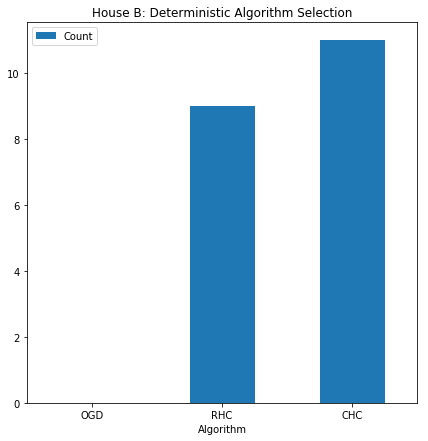

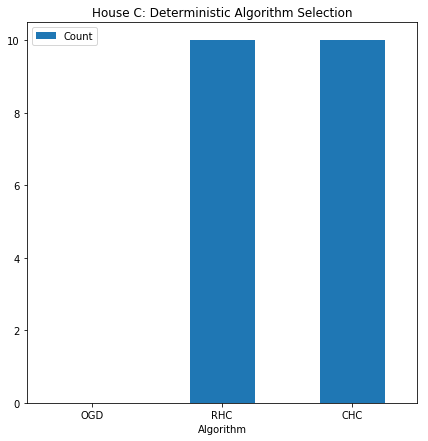

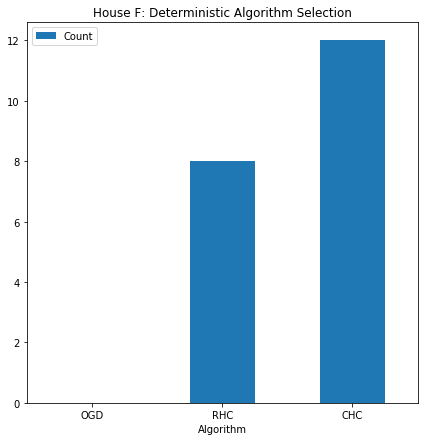

In [325]:
def deterministicselection(homepowerarr,homerfpreddfarr,house):
    timeframe = 32
    counter=0
    window=25
    commitment = 10
    rhc_count =0
    chc_count = 0
    ogd_count = 0
    price = 0.2 
    a=2 
    b=2 
    
    while counter + timeframe < 672:
        homepowerarr_frame = homepowerarr[counter:counter+timeframe]
        homerfpreddfarr_frame = homerfpreddfarr[counter:counter+timeframe]
        
        rhc_provision = GetRHC(a,b,homerfpreddfarr_frame,window,price)
        cost_rhc = getCost(homepowerarr_frame,rhc_provision,price,a,b)
        currentmin = cost_rhc
        
        chc_provision = GetCHC(a,b,homerfpreddfarr_frame,window,commitment,price)
        cost_chc = getCost(homepowerarr_frame,chc_provision,price,a,b)
        
        if(cost_chc < currentmin):
            currentmin = cost_chc
            
        stepsize=[] 
        for j in range (1,len(homepowerarr_frame)):
            stepsize.append(1/j)
        
        ogd_provision = OnlineGradientDescent(homepowerarr_frame,stepsize,price,a,b)
        cost_ogd = getCost(homepowerarr_frame,ogd_provision,price,a,b)
        
        if(cost_ogd < currentmin):
            currentmin = cost_ogd
            
        if(currentmin==cost_rhc):
            rhc_count+=1
        elif(currentmin==cost_chc):
            chc_count+=1  
        else:
            ogd_count+=1  
        
        counter = counter + timeframe

    df = pd.DataFrame({'Algorithm':['OGD','RHC', 'CHC'], 'Count':[ogd_count,rhc_count,chc_count]})
    titleplot = "House "+house+": Deterministic Algorithm Selection"
    ax = df.plot.bar(x='Algorithm', y='Count', rot=0,figsize=(7,7),title=titleplot)

deterministicselection(homebpowerarr,homebrfpreddfarr,"B")
deterministicselection(homecpowerarr,homecrfpreddfarr,"C")
deterministicselection(homefpowerarr,homefrfpreddfarr,"F")

According to the above plot, we can see that CHC was the most effecient algorithm amongst all the three online algorithms for all the Houses followed by RHC and then OGD.

#### 2. Randomized Algorithm Selection

The basic idea behind this is to find the most effecient algorithms among the three for all sub intervals of the data. At each sub interval, we define a probabilistic value considering the most effecient to least effecient algorithm. Now, we pick an algorithm from that probabilistic distribution to get our effecient algorithm. At the end of all the intervals, return the algorithm which was effecient in most of the sub intervals.

Algorithm:
1. Initializing counters and variables. Setting the timeframe value to 32 which will iterate over the data 21 times. Therefore, I will be having 21 sub intervals and will be finding my effecient algorithm among the 21 results obtained by shifting the timeframe till all the observations are parsed.
2. Fixing the window size to be 25 and commitment horizon value to be 10 which was found to be closes to the optimal value in the above algorithms.
3. Initialize the counters and the parameters.
4. Iterate till all the 672 observations are parsed incrementing the timeframe by 32 as mentioned in Point 1.
5. At each iteration, find the cost of all the online algorithms, i.e. OGD, RHC and CHC
6. Based on the cost, get the ordered list of values to assign the probabilities. Here, we are assigning 0.5 to the best cost, i.e. algorithm with minimum cost, assigning 0.3 to the 2nd best cost and assigning 0.2 to the worst cost, i.e. algorithm with the maximum cost.
7. Randomly select an algorithm from this probability.
8. Increment the counter of the algorithm which was picked up randomly in step 6.
9. After the iteration, plot the count values of the three algorithms to find the most effecient algorithm selected by the random algorithm.

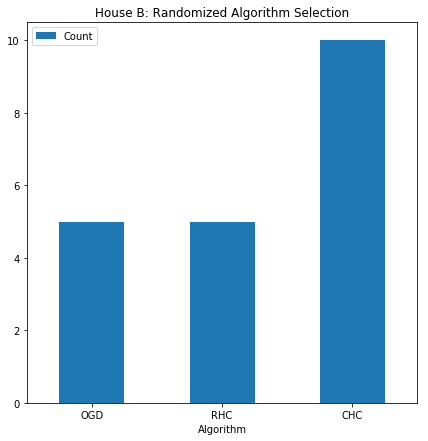

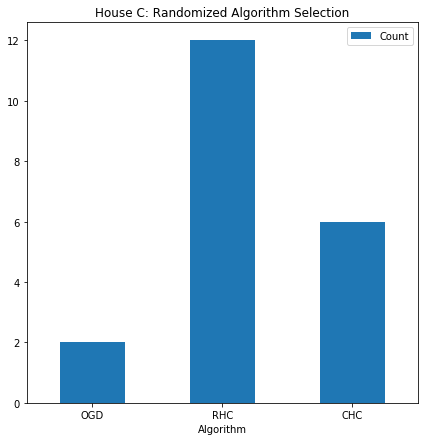

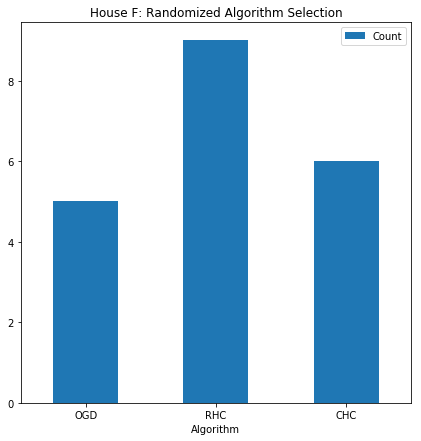

In [326]:
def randomizedselection(homepowerarr,homerfpreddfarr,house):
    price = 0.2 
    a=2
    b=2
    timeframe = 32
    counter=0
    window=25
    commitment = 10
    rhc_count =0
    chc_count = 0
    ogd_count = 0
    distribution_last = 0.2
    distribution_middle = 0.3
    distribution_first = 0.5
        
    while counter + timeframe < 672:
        homepowerarr_frame = homepowerarr[counter:counter+timeframe]
        homerfpreddfarr_frame = homerfpreddfarr[counter:counter+timeframe]
        
        listsort=[]   
        rhc_provision = GetRHC(a,b,homerfpreddfarr_frame,window,price)
        cost_rhc = getCost(homepowerarr_frame,rhc_provision,price,a,b)
        listsort.append(cost_rhc)
        
        chc_provision = GetCHC(a,b,homerfpreddfarr_frame,window,commitment,price)
        cost_chc = getCost(homepowerarr_frame,chc_provision,price,a,b)
        listsort.append(cost_chc)
        
        stepsize=[] 
        for j in range (1,len(homepowerarr_frame)):
            stepsize.append(1/j)
        
        ogd_provision = OnlineGradientDescent(homepowerarr_frame,stepsize,price,a,b)
        cost_ogd = getCost(homepowerarr_frame,ogd_provision,price,a,b)
        listsort.append(cost_ogd)
        
        listsort.sort(reverse=True)
        
        distribution_ogd = 1
        distribution_rhc = 1
        distribution_chc = 1
                
        if (listsort[0]==cost_ogd):
            distribution_ogd = distribution_last
        if (listsort[0]==cost_rhc):
            distribution_rhc = distribution_last
        else:
            distribution_chc = distribution_last
            
        if (listsort[1]==cost_ogd):
            distribution_ogd = distribution_middle
        if (listsort[1]==cost_rhc):
            distribution_rhc = distribution_middle
        else:
            distribution_chc = distribution_middle
            
        if (listsort[2]==cost_ogd):
            distribution_ogd = distribution_first
        if (listsort[2]==cost_rhc):
            distribution_rhc = distribution_first
        else:
            distribution_chc = distribution_first
                        
        choice = np.random.choice(
          ['RHC', 'CHC', 'OGD'], 
          p=[distribution_rhc, distribution_chc, distribution_ogd]
        )
        
        if(choice == "RHC"):
            rhc_count+=1
        elif(choice=="CHC"):
            chc_count+=1  
        else:
            ogd_count+=1  

        counter = counter + timeframe

    df = pd.DataFrame({'Algorithm':['OGD', 'RHC', 'CHC'], 'Count':[ogd_count, rhc_count, chc_count]})
    titleplot = "House "+house+": Randomized Algorithm Selection"
    ax = df.plot.bar(x='Algorithm', y='Count', rot=0,figsize=(7,7),title=titleplot)

randomizedselection(homebpowerarr,homebrfpreddfarr,"B")
randomizedselection(homecpowerarr,homecrfpreddfarr,"C")
randomizedselection(homefpowerarr,homefrfpreddfarr,"F")

According to the above plot, we can see that CHC was the most effecient algorithm for House B and RHC was the most effecient algorithm for House C and F. Since, it works on a random value, we are not able to control the output of the random selection algorithm. If we run the same program again, there are high probabilities that another algorithm can turn out to be more efficient.

Another thing, which could have been done to improve the scores is that take the most optimal score for each algorithm and solve it until the exact precision is found. Here, we are taking comitment levels as 10 and window size as 25 for all the Houses. It could have behaved better, if we would have taken a more personalised approach than generalising it. But in practical scenarios, it is always better to generalise so that it can be comparable across different datasets of the same domain. Personalised algorithms tuning can help us to predict and provision better for particular Homes only.

## Bonus Questions

### Online balanced Descent Algorithm

Online Balanced Descent Algorithm develops over Online Gradient Descent Algorithm. In Online Gradient Decent Algorithm, stepsize remains constant, whereas in Online Balanced Descent Algorithm, step size changes over time. Please find below a modification code from the Online Gradient Descent Algorithm to formulate Online Balanced Descent Algorithm.

Online Balanced Descent Algorithm


,House,Cost
0,B,409.486401
1,C,10267.936369
2,F,27506.092103


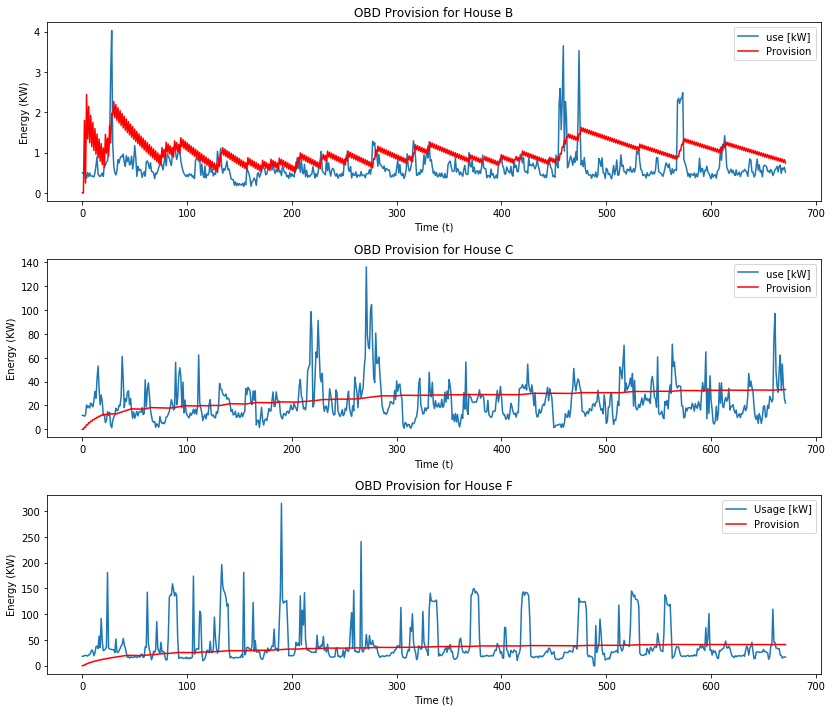

In [331]:
obd_cost = []
o_house_type = []

def OnlineBalancedDescent(homepowerarr,step,price,a,b):
    provision = [0]*len(homepowerarr)
    for t in range(1,len(homepowerarr)-1):
        gradient =derivative(t,provision,homepowerarr,price)
        
        # Changing step size with time -> 1/t
        provision[t+1] = provision[t] - (1/(t+1))*(gradient)
    return provision

def calcOBD(homepowerarr, homepowerdf, house, column, number):  
    provision = OnlineGradientDescent(homepowerarr,stepsize,price,a,b)
    cost = FindCost(homepowerarr,provision,price,a,b)
    obd_cost.append(cost)
    o_house_type.append(house)
    graphPlot(provision,homepowerdf,column,number,0,"OBD Provision for House "+house)


fig = plt.figure(figsize=(23,10))
axes = fig.subplots(nrows=3, ncols=2)

calcOBD(homebpowerarr, homebpowerdf, "B", "use [kW]", 0)
calcOBD(homecpowerarr, homecpowerdf, "C", "use [kW]", 1)
calcOBD(homefpowerarr, homefpowerdf, "F", "Usage [kW]", 2)

plt.tight_layout()
fig.delaxes(axes[0][1])
fig.delaxes(axes[1][1])
fig.delaxes(axes[2][1])

comparison = pd.DataFrame({
    'House': o_house_type,
    'Cost': obd_cost,
})

print("Online Balanced Descent Algorithm")
display(comparison)

### Another Algorithm Selection Method

For Deterministic approach above, I have used Cost as the determining value for the most efficient algorithm. In another approach, as mentioned above, I can use regret factor for determining the most efficient algorithm. This will be a more better approach as it acts as a relative method from offline static/dynamic optimization algorithms.

For Randomized approach, we can have another random logic to find the algorithm. We can assign random numbers to all the algorithms. A random finction will pick a number. Based on the selected number, we increase the counter of the algorithm selection. We can repeat the process for higher number of times, say 500, and determine which algorithm to select. Please find below the approach for this random selection algorithm.

In [337]:
rhc_count =0 #Assigned Value 2
chc_count = 0 #Assigned Value 3
ogd_count = 0 #Assigned Value 0
obd_count = 0 #Assigned Value 1

count = []

for i in range(500):
    random_number = np.random.randint(4)
    if random_number == 0:
        ogd_count+=1
    if random_number == 1:
        obd_count+=1
    if random_number == 2:
        rhc_count+=1
    if random_number == 3:
        chc_count+=1
        
print("Another Random Selection Method")
print("Online Gradient Descent Count: ", ogd_count)
print("Online Balanced Descent Count: ", obd_count)
print("Receding Horizon Control: ", rhc_count)
print("Commitment Horizon Control: ", chc_count)

Another Random Selection Method
Online Gradient Descent Count:  135
Online Balanced Descent Count:  128
Receding Horizon Control:  115
Commitment Horizon Control:  122


Here, Online Gradient Descent Algorithm is selected as it has the max count value. Probably, different algorithm is selected if we run the same program again.